In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats,signal
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, StackedHisto, SimpleHisto, mcplot, DrawMatrix

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.22/02


In [8]:
datafolder = '../../rootFiles/1mu1p_selection'
auxfolder = '../aux'
tag = '2021-03-30'
plotfolder = '../outputs/PlotDumpsForDavio'+tag
covfolder = '../outputs/covMatrixForDavio'+tag
covtag = 'frac_covar_run3_%s'%tag



RSE  = ['run','subrun','event']

# RUN 3 

In [9]:
run = 'run3'
f_scaleslist = []
s_detsyslist = []
names = ['wiremodX','wiremodYZ','recomb','LYdown','LYAtt','LYRayleigh','SCE','wiremodThetaYZ','wiremodThetaXZ']

for name in names:
    s_detsyslist.append(name)

a_df_sys = []

RSE = ['run','subrun','event']
i=0
for sys in s_detsyslist:
#    print('111')
    df_sys = pd.read_parquet('%s/pickles/%s_%s_%s.parquet'%(datafolder,sys,run,tag))
#    print(df_sys.shape[0])
    i+=1
    a_df_sys.append(df_sys)
    print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))
#    print(df_sys.shape[0])

#df_numu_run3_presel = pd.read_parquet('../../data/pickles/numu_run1_nodupesMay1.parquet')
#print((list(a_df_sys[7])))


total 71256, cv = 58791 dv = 12465
total 71341, cv = 58791 dv = 12550
total 12286, cv = 5919 dv = 6367
total 70231, cv = 58791 dv = 11440
total 70238, cv = 58791 dv = 11447
total 71362, cv = 58791 dv = 12571
total 12061, cv = 5919 dv = 6142
total 70893, cv = 58791 dv = 12102
total 70891, cv = 58791 dv = 12100


In [10]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
#varlistSel = {}

varListSel = {}
varListSel['Xreco'] = distVar('Xreco',(15,241.25),14,'Reco Vertex X',datafolder+'/'+covfolder+'/'+covtag+'__x_reco.txt')



varListSel['Yreco'] = distVar('Yreco',(-101.5,101.5),14,'Reco Vertex Y',datafolder+'/'+covfolder+'/'+covtag+'__y_reco.txt')
varListSel['Zreco'] = distVar('Zreco',(15,1021.8),14,'Reco Vertex Z',datafolder+'/'+covfolder+'/'+covtag+'__z_reco.txt')
varListSel['OpenAng'] = distVar('OpenAng',(.6,2.8),14,'Opening Angle (rads)',datafolder+'/'+covfolder+'/'+covtag+'__openang_reco.txt')
varListSel['Thetas'] = distVar('Thetas',(0,np.pi),14,r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_thetas_reco.txt')
varListSel['Phis'] = distVar('Phis',(1.5,4),14,r'Difference of Phis ($|\phi_{p} - \phi_{\mu}|$)  (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_phis_reco.txt')
varListSel['ChargeNearTrunk'] = distVar('ChargeNearTrunk',(0,600),14,'ADC Charge within 5cm of Reco Vertex',datafolder+'/'+covfolder+'/'+covtag+'__charge_near_trunk_reco.txt')
varListSel['Enu_1m1p'] = distVar('Enu_1m1p',(200,1200),20,'Reconstructed Neutrino Energy (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__nu_energy_reco.txt')
varListSel['PhiT_1m1p'] = distVar('PhiT_1m1p',(0,1),14,r'$\phi_T$',datafolder+'/'+covfolder+'/'+covtag+'__phiT_reco.txt')
varListSel['AlphaT_1m1p'] = distVar('AlphaT_1m1p',(0,np.pi),14,r'$\alpha_T$',datafolder+'/'+covfolder+'/'+covtag+'__alphaT_reco.txt')
varListSel['PT_1m1p'] = distVar('PT_1m1p',(0,320),14,r'$p_T$',datafolder+'/'+covfolder+'/'+covtag+'__pT_reco.txt')
varListSel['PTRat_1m1p'] = distVar('PTRat_1m1p',(0,.4),14,r'$p_T/|p|$',datafolder+'/'+covfolder+'/'+covtag+'__pT_ratio_reco.txt')
varListSel['BjXB_1m1p'] = distVar('BjXB_1m1p',(.2,1.8),14,'Bjorken X*',datafolder+'/'+covfolder+'/'+covtag+'__BjxB_reco.txt')
varListSel['BjYB_1m1p'] = distVar('BjYB_1m1p',(0.05,.75),14,'Bjorken Y*',datafolder+'/'+covfolder+'/'+covtag+'__BjyB_reco.txt')
varListSel['Q2_1m1p'] = distVar('Q2_1m1p',(0,6e5),14,r'$Q^2$',datafolder+'/'+covfolder+'/'+covtag+'__Q2_reco.txt')
varListSel['SphB_1m1p'] = distVar('SphB_1m1p',(0,1000),14,'QE Consistency*',datafolder+'/'+covfolder+'/'+covtag+'__sphB_reco.txt')
varListSel['Q0_1m1p'] = distVar('Q0_1m1p',(70,600),14,r'$Q_0$',datafolder+'/'+covfolder+'/'+covtag+'__Q0_reco.txt')
varListSel['Q3_1m1p'] = distVar('Q3_1m1p',(200,1000),14,r'$Q_3$',datafolder+'/'+covfolder+'/'+covtag+'__Q3_reco.txt')
varListSel['Lepton_PhiReco'] = distVar('Lepton_PhiReco',(-np.pi,np.pi),14,r'Muon $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_phi_reco.txt')
varListSel['Lepton_ThetaReco'] = distVar('Lepton_ThetaReco',(.2,2.8),14,r'Muon $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_theta_reco.txt')
varListSel['Lepton_TrackLength'] = distVar('Lepton_TrackLength',(20,200),14,'Muon Track Length (cm)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_length_reco.txt')
varListSel['Muon_Edep'] = distVar('Muon_Edep',(50,600),14,'Reco Muon Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_KE_reco.txt')
varListSel['Proton_PhiReco'] = distVar('Proton_PhiReco',(-np.pi,np.pi),14,r'Proton $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__proton_phi_reco.txt')
varListSel['Proton_ThetaReco'] = distVar('Proton_ThetaReco',(0,2),14,r'Proton $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__proton_theta_reco.txt')
varListSel['Proton_TrackLength'] = distVar('Proton_TrackLength',(5,100),14,'Proton Track Length',datafolder+'/'+covfolder+'/'+covtag+'__proton_length_reco.txt')
varListSel['Proton_Edep'] = distVar('Proton_Edep',(50,500),14,'Reco Proton Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__proton_KE_reco.txt')
varListSel['Proton_CosTheta'] = distVar('Proton_CosTheta',(0,1),14,'Proton Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__proton_cos_theta_reco.txt')
varListSel['Lepton_CosTheta'] = distVar('Lepton_CosTheta',(-1,1),14,'Muon Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__lepton_cos_theta_reco.txt')
varListSel['MPID_eminus'] = distVar('MPID_eminus',(0,1),14,'Eminus MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_eminus_score.txt')
varListSel['MPID_muon'] = distVar('MPID_muon',(0,1),14,'Muon MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_muon_score.txt')
varListSel['MPID_proton'] = distVar('MPID_proton',(0,1),14,'Proton MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_proton_score.txt')
varListSel['MPID_gamma'] = distVar('MPID_gamma',(0,1),14,'Gamma MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_gamma_score.txt')
varListSel['MPID_pion'] = distVar('MPID_pion',(0,1),14,'Pion MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_pion_score.txt')




In [11]:
for _,dist in varListSel.items(): # loop over all variables 
    print(dist.myname)


Xreco
Yreco
Zreco
OpenAng
Thetas
Phis
ChargeNearTrunk
Enu_1m1p
PhiT_1m1p
AlphaT_1m1p
PT_1m1p
PTRat_1m1p
BjXB_1m1p
BjYB_1m1p
Q2_1m1p
SphB_1m1p
Q0_1m1p
Q3_1m1p
Lepton_PhiReco
Lepton_ThetaReco
Lepton_TrackLength
Muon_Edep
Proton_PhiReco
Proton_ThetaReco
Proton_TrackLength
Proton_Edep
Proton_CosTheta
Lepton_CosTheta
MPID_eminus
MPID_muon
MPID_proton
MPID_gamma
MPID_pion


# Build Covariance Matrices!

In [12]:
# define cuts
Ecut = 'Enu_1m1p > 200 and Enu_1m1p<=1200'
precuts = 'PassPrecuts1m1p==1'
bdtcuts = ' bkgBDT_univ< .4'
morecuts = 'Proton_CosTheta > 0'
bonuscuts = '(MPID_proton > .9 or Enu_1m1p > 400)'
#bdtcuts = 'bdt_run3_cosmic < .5 and bdt_run3_nu < .5'
s_cuts = bonuscuts + ' and ' + Ecut + ' and ' +  bdtcuts + ' and ' +  morecuts + ' and ' +  'isCV ==False'
s_cuts_cv = bonuscuts + ' and '+ Ecut + ' and ' +  bdtcuts + ' and ' +  morecuts + ' and ' +  'isCV ==True' 



In [13]:
#Bring in the required modules
from scipy import *
from scipy import signal
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import lfilter
import scipy.signal
from scipy.optimize import leastsq
import pandas as pd
import scipy.stats as stats
import matplotlib.mlab as mlab
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from random import random




def smooth(cv_list,dv_list,xmin,xmax,dv_name,cv_weights=1,dv_weights=1,ratio=1,nbin=20):
    
#----------------------------------------------------------------
# This section is the CV
    ext_bin=10
    cv = np.array(cv_list)
    dv = np.array(dv_list)
    cv_w = np.array(cv_weights+0.00000001)
    dv_w = np.array(dv_weights+0.00000001)

    if (cv_w.size==1 or dv_w.size==1):
        cv_w = np.ones(cv.size)
        dv_w = np.ones(dv.size)
    elif (cv.size != cv_w.size or dv.size != dv_w.size):
        print('##############     ERROR weights and lists are not matching sizes ####################')
        return(0,0)
    
             
# throw away the data points outside of the hist limits to fake the real data
#    mask1 = np.logical_and(cv >= xmin, cv <= xmax)
#    cv = cv[mask1]
        
    cv_hist, binedges = np.histogram(cv, bins = nbin, range = (xmin, xmax),weights=cv_w)
    cv_hist= cv_hist+0.000001 # assure no zero bins    


#-------------------------------------------------------------------------------
# look for spikes at edges and remove them.  Smoothing cannot handle these.
    
    # flags for bin drops
    drop0=False
    dropn=False
    
    # throw away the first bin if needed
    # do this if the change is more than 80%
    print('cv[0] =  %f    cv[1] = %f  rat = %f'%(cv[0],cv[1],cv[0]/(cv[0]+cv[1])))

    if ((cv_hist[0]/(cv_hist[0]+cv_hist[1]))>0.80):
        drop0=True

    if ((cv_hist[nbin-1]/(cv_hist[nbin-2]+cv_hist[nbin-1]))>0.80):
        dropn=True


    # throw away the firstand/or last bin if needed
        
    if (drop0):    
        mask1 = np.logical_and(cv >= binedges[1], cv <= xmax)
        cv = cv[mask1]
        cv_w = cv_w[mask1]
        print('----------------------------drop0_cv')
        
    if (dropn):
        mask1 = np.logical_and(cv >= xmin, cv <=  binedges[nbin-1])
        cv = cv[mask1]
        cv_w = cv_w[mask1]

        print('dropn_cv')
    
        
    #-------------------------------------------------------------------------------
# CV smoothing, calculate the bandwidth for use throughout
        
        
# calculate Sheather/Jones bandwidth
    bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
    print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
    print(cv_hist)
    # This smoothing library wants 2d so pad it out
    cv2d=cv [:, np.newaxis]

    
    myrange = (lambda edges: (edges[:-1] + edges[1:])/2.0)(np.linspace(xmin,xmax,(ext_bin*nbin)+1))
    range2d=myrange [:, np.newaxis]
#    print(myrange)

#----------------------------------------------------------------
# This section is the detvar

#
# Create Fake data np.histograms,aiming for about 4000 events in the np.histogram
#
    # This smoothing library wants 2d so pad it out
    dv_hist, binedges = np.histogram(dv, bins = nbin, range = (xmin, xmax),weights=dv_w)
    dv_hist= ratio*dv_hist+0.000001 # assure no zero bins    

    # throw away the firstand/or last bin if needed
        
    if (drop0):    
        mask1 = np.logical_and(dv >= binedges[1], dv <= xmax)
        print('dv length = %d and dv_w length =%d'%(dv.size,dv_w.size))
        dv = dv[mask1]
        print('-----------------------------------drop0_dv')
        print('dv length = %d and dv_w length =%d'%(dv.size,dv_w.size))
        dv_w = dv_w[mask1]
        print('dv length = %d and dv_w length =%d'%(dv.size,dv_w.size))

        
    if (dropn):
        mask1 = np.logical_and(dv >= xmin, dv <=  binedges[nbin-1])
        dv = dv[mask1]
        print('dropn_dv')
        dv_w = dv_w[mask1]

    dv2d=dv [:, np.newaxis]

#----------------------------------------------------------------
# Smooth both CV AND DV, Fix up the edge bins.
         
    #get the CV smoothed case and normalize it

    gkdeCV= KernelDensity(kernel='epanechnikov', bandwidth=bwid).fit(cv2d,sample_weight=cv_w)
    mykdeCV = np.exp(gkdeCV.score_samples(range2d))
    yhatCV=np.zeros(ext_bin*nbin)
#    yhatCV=(mykdeCV)*(cv.shape[0])/sum(mykdeCV)
    yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)

    
    
    
    
    #get the DV smoothed case and normalize it
    gkdeDV= KernelDensity(kernel='epanechnikov', bandwidth=bwid).fit(dv2d,sample_weight=dv_w)
    
    mykdeDV = np.exp(gkdeDV.score_samples(range2d))

    yhatDV=np.zeros(ext_bin*nbin)
#    yhatDV=(mykdeDV)*dv.shape[0]/sum(mykdeDV)
    yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)
    
    # rebin the ratio into the bins we will use by summing the bin...
    smoothrat=np.zeros(nbin)
    smoothCV=np.zeros(nbin)
    smoothDV=np.zeros(nbin)

    k=0
    
    for j in range(nbin):
        ratvalCV=0.
        ratvalDV=0.
        for n in range(ext_bin):
            ratvalCV+=yhatCV[k]
            ratvalDV+=yhatDV[k]
            k+=1
        if ratvalCV==0:
            smoothrat[j]=1
        else:
            smoothrat[j]=ratvalDV/ratvalCV
        smoothCV[j]=ratvalCV
        smoothDV[j]=ratvalDV

    # put the first and/or last bin back if needed
    if (drop0):
        smoothrat[0]=dv_hist[0]/cv_hist[0]
        smoothCV[0]=cv_hist[0]
        smoothDV[0]=dv_hist[0]

    if (dropn):
        smoothrat[nbin-1]=dv_hist[nbin-1]/cv_hist[nbin-1]

    
    offset = (xmax - xmin )/(2*nbin)
    x= np.linspace(xmin+offset,xmax-offset,nbin)
    
    plt.plot(x, cv_hist, linewidth=1, linestyle="-", c="b",label='cv')  # smooth by filter
    plt.plot(x, dv_hist, linewidth=1, linestyle="-", c="g",label='dv')  # smooth by filter

    plt.plot(x, smoothCV, linewidth=1, linestyle="--", c="b",label='cv_smooth')  # smooth by filter

    plt.plot(x, smoothDV, linewidth=1, linestyle="--", c="g",label='dv_smooth')  # smooth by filter
    plt.legend()
    plt.title('%s %s'%(dist.mylabel,dv_name))
    plt.savefig(plotfolder_tmp+'/detsys_%s_%s_%s_full_hists.png'%(dist.myname, run,dv_name),dpi=120,bbox_inches='tight')
    
    plt.show()
    if(dv_hist[0]==0.000001):
        dv_hist[0]=0
    plt.plot(x, dv_hist/cv_hist, linewidth=1, linestyle="-", c="b",label='original')  # smooth by filter
    plt.plot(x,smoothrat , linewidth=1, linestyle="-", c="m",label='smoothed')  # smooth by filter
    plt.legend()
    plt.title('%s %s ratio'%(dist.mylabel,dv_name))

    plt.savefig(plotfolder_tmp+'/detsys_%s_%s_%s_ratio.png'%(dist.myname, run,dv_name),dpi=120,bbox_inches='tight')

    plt.show()

    
    return(smoothCV,smoothDV)



In [30]:
run = 'run3'
f_scaleslist = []
s_detsyslist = []
names = ['wiremodX','wiremodYZ','recomb','LYdown','LYAtt','SCE','wiremodThetaYZ','wiremodThetaXZ','LYRayleigh']

for name in names:
    s_detsyslist.append(name)

a_df_sys = []

RSE = ['run','subrun','event']
i=0
for sys in s_detsyslist:
#    print('111')
    df_sys = pd.read_parquet('%s/pickles/%s_%s_%s.parquet'%(datafolder,sys,run,tag))
#    print(df_sys.shape[0])
    i+=1
    a_df_sys.append(df_sys)
    print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))
#    print(df_sys.shape[0])

#df_numu_run3_presel = pd.read_parquet('../../data/pickles/numu_run1_nodupesMay1.parquet')
#print((list(a_df_sys[7])))


total 71256, cv = 58791 dv = 12465
total 71341, cv = 58791 dv = 12550
total 12286, cv = 5919 dv = 6367
total 70231, cv = 58791 dv = 11440
total 70238, cv = 58791 dv = 11447
total 12061, cv = 5919 dv = 6142
total 70893, cv = 58791 dv = 12102
total 70891, cv = 58791 dv = 12100
total 71362, cv = 58791 dv = 12571


../outputs/PlotDumpsForDavio2021-03-30/Enu_1m1p
9
0
cv = 3759  and dv = 5476
cv POT = 898773223801000034304.000000 dv POT = 1309153192370000101376.000000


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))


---------------------> CV entries = 3759.000000  and dv entries = 5476.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


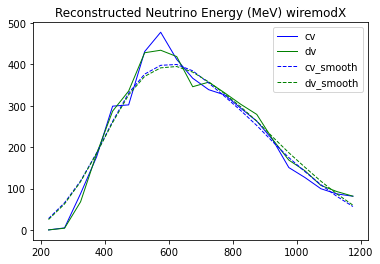

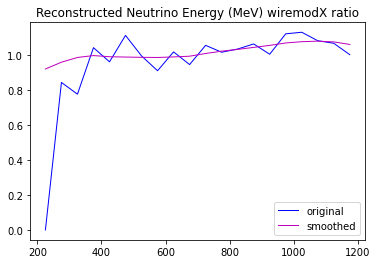

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4585.033794782068
4585.033852376463
Enu_1m1p [6.58027799e-03 1.79283133e-03 2.34013442e-04 1.98259945e-05
 1.24880419e-04 1.67200415e-04 2.09182415e-04 2.36189861e-04
 1.48661365e-04 6.60400543e-05 5.49104661e-05 4.24143055e-04
 9.48554681e-04 1.77755150e-03 2.88340878e-03 4.55270432e-03
 5.57524140e-03 6.05789450e-03 5.42321172e-03 3.47754086e-03]
Enu_1m1p [0.00000000e+00 2.49679068e-02 5.05503271e-02 1.65112816e-03
 1.61440395e-03 1.22616565e-02 4.18918594e-05 8.28685504e-03
 2.73095300e-04 3.12421662e-03 2.91203789e-03 2.14433546e-04
 1.07920128e-03 3.83800656e-03 9.72781078e-06 1.42989728e-02
 1.65647036e-02 6.45435578e-03 4.31138096e-03 4.11736741e-07]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


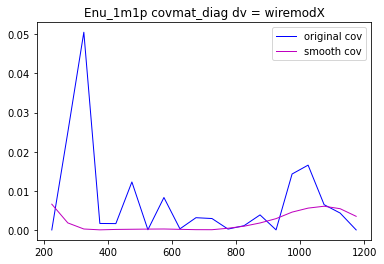

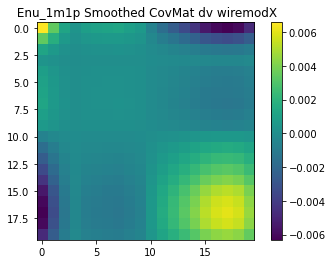

1
cv = 3759  and dv = 5541
cv POT = 898773223801000034304.000000 dv POT = 1310970606080000000000.000000
---------------------> CV entries = 3759.000000  and dv entries = 5541.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(myk

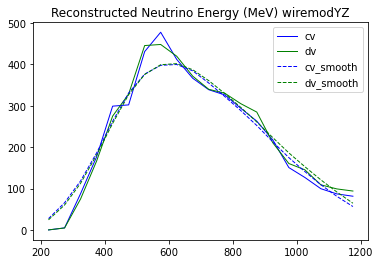

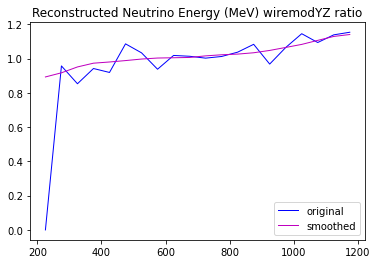

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4608.97371266023
4608.9737706481355
Enu_1m1p [1.14319306e-02 6.84717792e-03 2.35237476e-03 7.06257457e-04
 3.84377619e-04 1.29402165e-04 5.90247834e-06 1.20221967e-05
 2.66286242e-05 4.69133363e-05 2.58842051e-04 5.08784060e-04
 6.99915907e-04 1.17351271e-03 2.29253378e-03 4.26162732e-03
 6.90550180e-03 1.13683758e-02 1.67874637e-02 1.98300004e-02]
Enu_1m1p [0.00000000e+00 1.81457434e-03 2.15085622e-02 3.32922962e-03
 6.51129852e-03 7.45070755e-03 1.14450761e-03 3.82428062e-03
 3.46949227e-04 1.89920849e-04 8.17367872e-06 1.58227858e-04
 1.42837294e-03 6.98162356e-03 1.00870244e-03 4.21410540e-03
 2.11775586e-02 8.85398311e-03 1.92870584e-02 2.37312625e-02]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


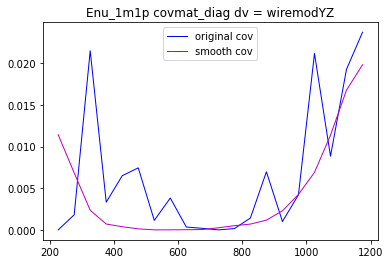

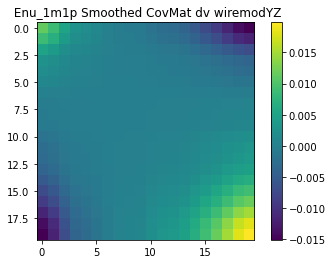

2
cv = 2670  and dv = 2916
cv POT = 579534847420999991296.000000 dv POT = 637062455184000024576.000000
---------------------> CV entries = 2670.000000  and dv entries = 2916.000000
cv[0] =  840.759705    cv[1] = 897.438660  rat = 0.483696
bwid = 200.342671 xmax-xmin=1000.000000  sum_cv = 3040.672351
[1.00000000e-06 2.00000102e+00 4.72302981e+01 1.18145360e+02
 1.97252056e+02 2.40363346e+02 2.81772118e+02 2.91355713e+02
 3.10087734e+02 2.73731477e+02 2.28899138e+02 2.15600208e+02
 1.84964508e+02 1.63985856e+02 1.37787316e+02 1.01708168e+02
 8.55575649e+01 6.46949231e+01 4.55298950e+01 5.00066699e+01]


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(myk

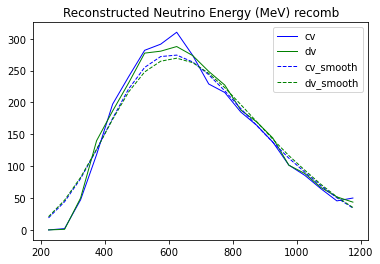

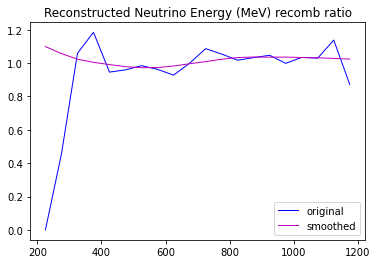

--------------------------  Hi There --------------------
3040.672304381558
3040.672351081559
3056.3299681874537
3056.3300147142663
Enu_1m1p [9.75327382e-03 3.24361951e-03 5.43683867e-04 1.84094553e-05
 8.51966066e-05 4.58648643e-04 7.75047469e-04 7.21786900e-04
 3.12008132e-04 1.84111980e-05 7.87377379e-05 5.14613080e-04
 1.07861907e-03 1.31414768e-03 1.24477200e-03 1.28289579e-03
 1.09885849e-03 9.92153734e-04 7.81356133e-04 5.67558440e-04]
Enu_1m1p [0.00000000e+00 2.97189265e-01 3.37244442e-03 3.41085714e-02
 2.94972145e-03 1.66216356e-03 2.46448162e-04 1.41965027e-03
 5.23527364e-03 8.00765953e-07 7.44564086e-03 2.92145934e-03
 2.86986610e-04 1.06821138e-03 2.16815398e-03 3.19068476e-06
 1.15169872e-03 8.75795514e-04 1.89660234e-02 1.65824858e-02]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


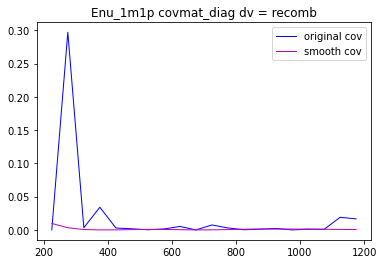

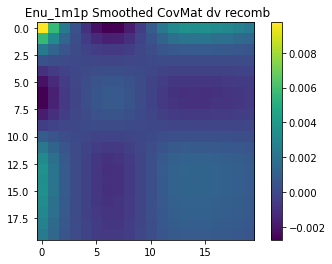

3
cv = 3759  and dv = 5082
cv POT = 898773223801000034304.000000 dv POT = 1218083168320000098304.000000


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))


---------------------> CV entries = 3759.000000  and dv entries = 5082.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


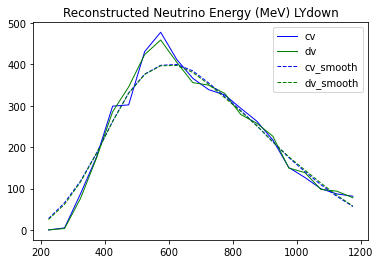

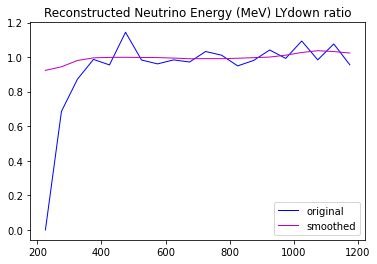

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4526.094292878033
4526.094350376013
Enu_1m1p [5.89260221e-03 3.15574734e-03 3.83702276e-04 2.03539865e-05
 3.45243919e-06 1.14833377e-06 4.91700873e-06 8.54684361e-06
 3.27573179e-05 9.33020127e-05 7.84122823e-05 8.76946699e-05
 4.43757174e-05 1.13476231e-05 2.00078678e-08 1.22613798e-04
 7.12900076e-04 1.36069844e-03 1.02600896e-03 5.49949076e-04]
Enu_1m1p [0.00000000e+00 9.88498788e-02 1.63434447e-02 1.82558579e-04
 2.04987478e-03 2.06628094e-02 2.85176187e-04 1.54757870e-03
 2.65005181e-04 8.15712395e-04 1.04058051e-03 1.18899707e-04
 2.60048551e-03 3.67123889e-04 1.68343937e-03 5.77151146e-05
 8.66383714e-03 2.57221029e-04 5.78116271e-03 1.95055397e-03]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


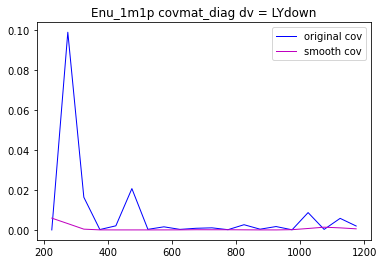

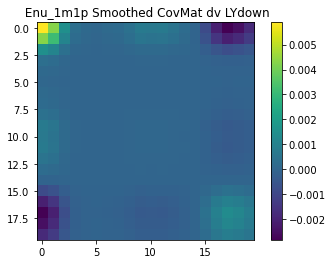

4
cv = 3759  and dv = 5079
cv POT = 898773223801000034304.000000 dv POT = 1212833087030000091136.000000
---------------------> CV entries = 3759.000000  and dv entries = 5079.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(myk

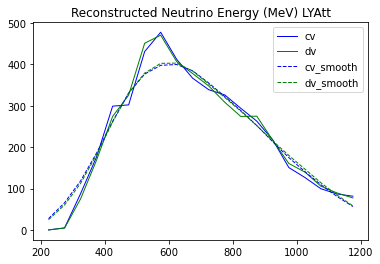

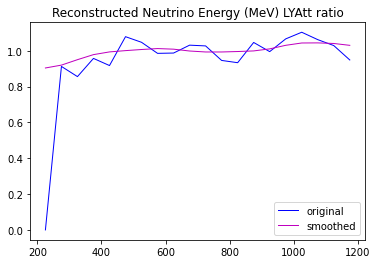

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4545.729043348353
4545.729100986419
Enu_1m1p [9.31861189e-03 6.48674954e-03 2.52113303e-03 4.86155429e-04
 4.70533657e-05 9.35730639e-08 4.28110466e-05 1.38192634e-04
 7.04495352e-05 3.36034661e-06 5.22272337e-05 5.23417086e-05
 2.24885790e-05 1.84940250e-06 1.00728519e-04 8.95162618e-04
 1.84001083e-03 1.88754210e-03 1.61470921e-03 8.85441936e-04]
Enu_1m1p [0.00000000e+00 7.72216326e-03 2.09274814e-02 1.86371359e-03
 6.88800273e-03 6.10326211e-03 2.18425813e-03 2.23400784e-04
 1.75109275e-04 9.46801540e-04 7.06197582e-04 2.96335750e-03
 4.49957489e-03 2.10111938e-03 2.84835344e-05 4.32201172e-03
 1.05754397e-02 3.79780707e-03 8.14063202e-04 2.68816221e-03]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


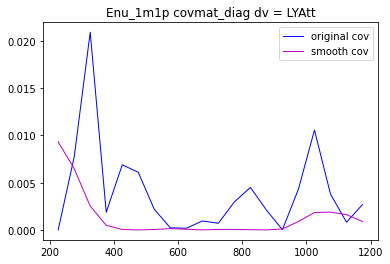

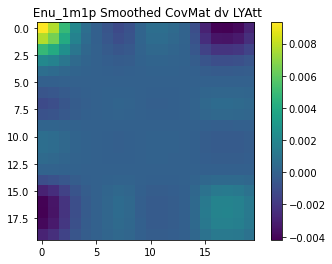

5
cv = 2670  and dv = 2738
cv POT = 579534847420999991296.000000 dv POT = 589862945463999987712.000000
---------------------> CV entries = 2670.000000  and dv entries = 2738.000000
cv[0] =  840.759705    cv[1] = 897.438660  rat = 0.483696
bwid = 200.342671 xmax-xmin=1000.000000  sum_cv = 3040.672351
[1.00000000e-06 2.00000102e+00 4.72302981e+01 1.18145360e+02
 1.97252056e+02 2.40363346e+02 2.81772118e+02 2.91355713e+02
 3.10087734e+02 2.73731477e+02 2.28899138e+02 2.15600208e+02
 1.84964508e+02 1.63985856e+02 1.37787316e+02 1.01708168e+02
 8.55575649e+01 6.46949231e+01 4.55298950e+01 5.00066699e+01]


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(myk

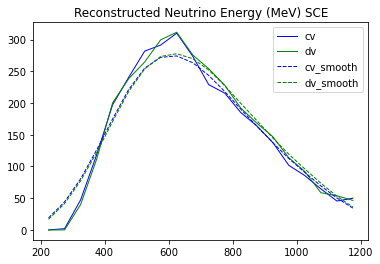

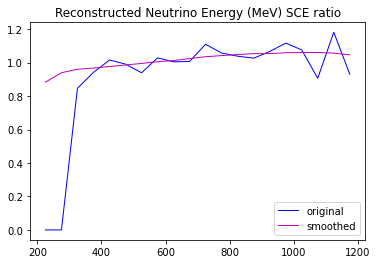

--------------------------  Hi There --------------------
3040.672304381558
3040.6723510815596
3095.433682922177
3095.4337298227724
Enu_1m1p [1.36437621e-02 3.63859455e-03 1.56990326e-03 1.06017727e-03
 5.34286841e-04 1.95963374e-04 2.24870904e-05 2.93569880e-05
 1.58800351e-04 5.83590108e-04 1.24818816e-03 1.77406742e-03
 2.30899340e-03 2.89200305e-03 2.92412396e-03 3.51132224e-03
 3.62764778e-03 3.71408138e-03 3.21308862e-03 2.15577118e-03]
Enu_1m1p [0.00000000e+00 1.00000000e+00 2.34648382e-02 3.39809482e-03
 2.43449868e-04 7.65157907e-05 3.69618697e-03 8.05565881e-04
 2.26126314e-05 5.25073469e-05 1.20354453e-02 3.30923993e-03
 1.47617006e-03 7.13564140e-04 4.42955384e-03 1.35939705e-02
 5.78750371e-03 8.72362828e-03 3.30050795e-02 4.77817008e-03]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


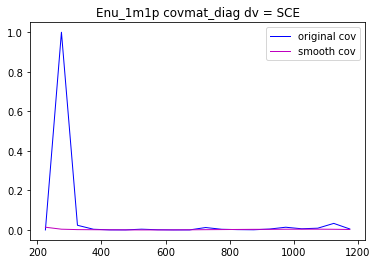

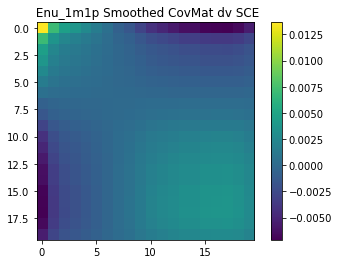

6
cv = 3759  and dv = 5313
cv POT = 898773223801000034304.000000 dv POT = 1264027045189999919104.000000
---------------------> CV entries = 3759.000000  and dv entries = 5313.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(myk

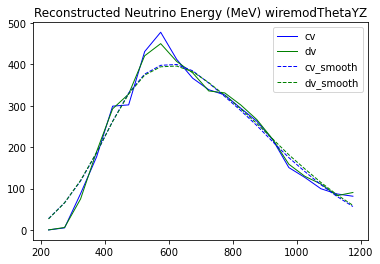

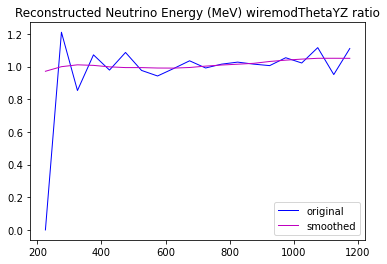

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4571.888883938484
4571.888941716018
Enu_1m1p [8.33630602e-04 5.43909444e-07 1.13015867e-04 5.30165019e-05
 3.27092524e-06 3.95050623e-05 4.09959001e-05 8.04741235e-05
 8.91550888e-05 3.29468442e-05 7.27528656e-06 8.90661814e-05
 2.08449115e-04 3.88608068e-04 9.68584956e-04 1.53679301e-03
 2.07991735e-03 2.55386185e-03 2.57807308e-03 2.54316695e-03]
Enu_1m1p [0.00000000e+00 4.41278062e-02 2.15291078e-02 5.13438176e-03
 4.65006262e-04 7.46155140e-03 5.57870251e-04 3.32573474e-03
 1.49723316e-04 1.24156507e-03 7.66425436e-05 2.18591218e-04
 7.38416889e-04 2.20263488e-04 3.33805598e-05 2.92245995e-03
 4.76554130e-04 1.34282916e-02 2.39859373e-03 1.21901267e-02]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


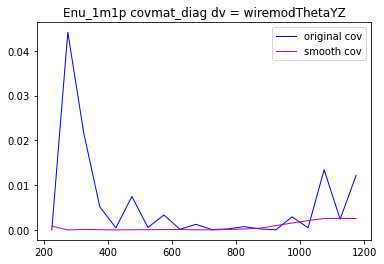

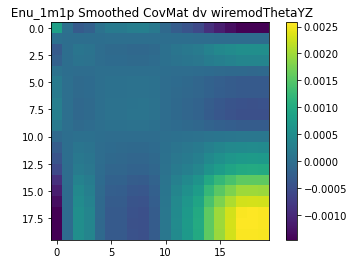

7
cv = 3759  and dv = 5357
cv POT = 898773223801000034304.000000 dv POT = 1296977725840000024576.000000
---------------------> CV entries = 3759.000000  and dv entries = 5357.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(myk

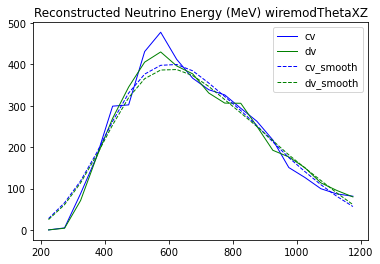

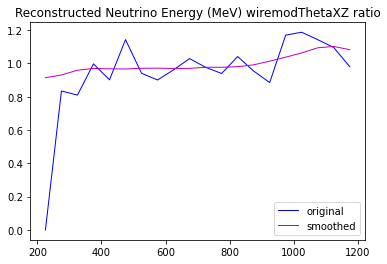

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4473.780447747171
4473.780504869845
Enu_1m1p [7.41985173e-03 4.84579943e-03 1.68651640e-03 9.02970731e-04
 1.06835158e-03 1.11609896e-03 8.67390773e-04 8.23801762e-04
 9.30277387e-04 9.00959283e-04 5.35272394e-04 5.44773355e-04
 3.85485769e-04 7.43839589e-05 1.84678634e-04 1.39126885e-03
 3.96211554e-03 8.77587451e-03 1.03634744e-02 6.75817929e-03]
Enu_1m1p [0.00000000e+00 2.74836364e-02 3.62185971e-02 7.59308538e-06
 9.73294739e-03 2.03676749e-02 3.50096495e-03 9.94011941e-03
 1.48090175e-03 8.30435409e-04 5.52783302e-04 3.68275833e-03
 1.69003973e-03 2.11787696e-03 1.32418193e-02 2.89191533e-02
 3.50031854e-02 2.03020137e-02 9.07973605e-03 3.88331268e-04]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


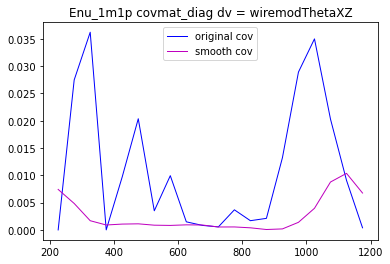

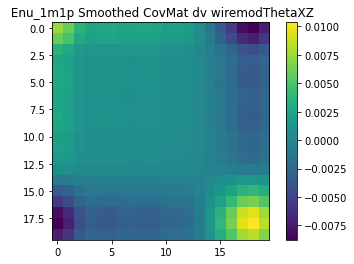

8
cv = 3759  and dv = 5578
cv POT = 898773223801000034304.000000 dv POT = 1308303170610000035840.000000
---------------------> CV entries = 3759.000000  and dv entries = 5578.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-31-c63a8bc1ef19>:63: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(myk

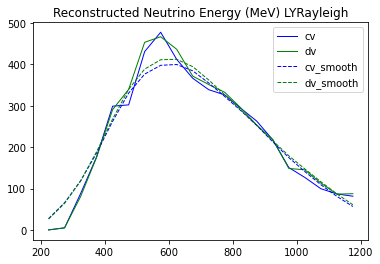

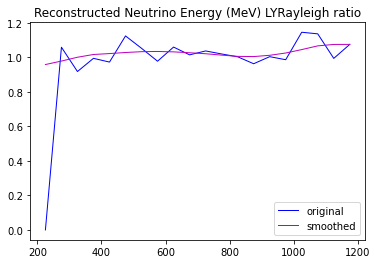

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4647.140742700829
4647.140801020366
Enu_1m1p [1.76664489e-03 4.76220756e-04 6.80458897e-08 2.62776325e-04
 4.62906230e-04 7.68183989e-04 1.05455639e-03 1.14482484e-03
 9.85065463e-04 6.91791737e-04 4.24144701e-04 1.57723716e-04
 2.81823247e-05 1.72267189e-05 1.32637273e-04 6.13522573e-04
 1.98827992e-03 4.37332071e-03 5.53939135e-03 5.56468150e-03]
Enu_1m1p [0.00000000e+00 3.40806961e-03 6.80850285e-03 3.66804980e-05
 7.70926366e-04 1.53225900e-02 2.71038812e-03 5.17229981e-04
 3.50426365e-03 1.98644151e-04 1.35413491e-03 3.71453687e-04
 8.33068361e-06 1.39703838e-03 1.32126122e-05 1.99386724e-04
 2.10488259e-02 1.84430196e-02 4.08718317e-05 5.59329441e-03]


<ipython-input-31-c63a8bc1ef19>:79: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-31-c63a8bc1ef19>:80: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-31-c63a8bc1ef19>:81: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-31-c63a8bc1ef19>:82: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


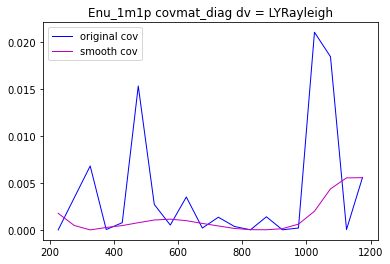

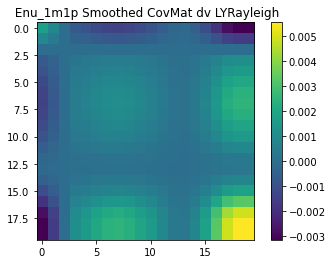

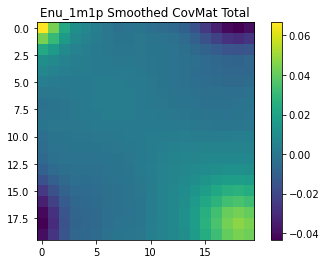

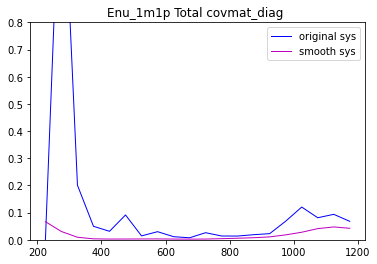

In [31]:
nbins = 20

if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)
if not os.path.exists(covfolder):
    os.makedirs(covfolder)

histOut = '/home/itran/SLAC_Work/ML/covmat_studies/HistsForCov/numu'
#for dist in varListSel: #[9:10]
#for _,dist in varListSel.items(): # loop over all variables 
#    var = dist.myname

#for i in range():
for var in (['Enu_1m1p']):#,'Q3_1m1p','Q0_1m1p','Q2_1m1p']):
    plotfolder_tmp = plotfolder+'/'+var
    if not os.path.exists(plotfolder_tmp):
        os.makedirs(plotfolder_tmp)
        print(plotfolder_tmp)
    covfolder_tmp = covfolder+'/'+var

    if not os.path.exists(covfolder_tmp):
        os.makedirs(covfolder_tmp)
#    dist = varListSel['Enu_1m1p']
    
    dist = varListSel[var]
    nbins = dist.nbins

    cov = np.zeros((nbins,nbins))
    cov_smooth = np.zeros((nbins,nbins))


    print(len(a_df_sys))
    for sysi in range(len(a_df_sys)): # loop over all detvars
#    for sysi in range(1):
#        sysi = 3
#        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        print(sysi)
        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0')
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts_cv)[dist.myname]
        print('cv = %d  and dv = %d'%(var_cv.shape[0],var_sys.shape[0]))

        pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
        pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
        print("cv POT = %f dv POT = %f"%(pot_cv,pot_dv))

        
        # get cv and detvar lists and apply weights
        var_cv_list = np.array(var_cv.astype(float).values.tolist())
        var_sys_list = np.array(var_sys.astype(float).values.tolist())
        cv_weights = np.array(myvardf.query(s_cuts_cv)['xsec_corr_weight'].astype(float).values.tolist())
        dv_weights = np.array(myvardf.query(s_cuts)['xsec_corr_weight'].astype(float).values.tolist())
        ratio = pot_cv / pot_dv

#        var_cv_list = var_cv_list * cv_weights 

#        var_sys_list = var_sys_list * sys_weights 
        
        
        hCV,binedges = np.histogram(var_cv_list,bins=nbins,range=dist.myrange)
        h0,_ = np.histogram(var_sys_list,bins=nbins,range=dist.myrange)#cv_scale)
        print('---------------------> CV entries = %f  and dv entries = %f'%(sum(hCV),sum(h0)))
        CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=cv_weights,dv_weights=dv_weights,nbin=nbins,ratio=ratio)
        #CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=1,dv_weights=1,nbin=nbins,ratio=ratio)
        np.save('%s/1Dhist_Enu_1m1p_run3_%s_CV_smooth.npy'%(histOut,names[sysi]), CV_smooth)
        np.save('%s/1Dhist_Enu_1m1p_run3_%s_DV_smooth.npy'%(histOut,names[sysi]), DV_smooth)


        
#        print(cv_weights)
        hCV,binedges = np.histogram(var_cv_list,bins=nbins,range=dist.myrange,weights= cv_weights)#cv_scale)
        h0,_ = np.histogram(var_sys_list,bins=nbins,range=dist.myrange,weights=dv_weights)#cv_scale)
        bincenters = np.diff(binedges)/2 + binedges[:-1] 
        h0 = h0 *ratio
        
        
        print('--------------------------  Hi There --------------------')
        print(sum(hCV))
        print(sum(CV_smooth))
        print(sum(h0))
        print(sum(DV_smooth))
    

        cov_tmp = np.zeros((nbins,nbins))
        cov_smooth_tmp = np.zeros((nbins,nbins))            
        for i in range(nbins):
            for j in range(nbins):
                if (hCV[i]*hCV[j])<1e-5:
                    cov_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
    #    print(dist.myname,cov.diagonal())
        for i in range(nbins):
            for j in range(nbins):
                if (CV_smooth[i]*CV_smooth[j])<1e-5:
                    cov_smooth_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_smooth_tmp[i][j] += (DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j])/(CV_smooth[i]*CV_smooth[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
        print(dist.myname,cov_smooth_tmp.diagonal())
        print(dist.myname,cov_tmp.diagonal())
        
        offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
        x= np.linspace(dist.myrange[0]+offset,dist.myrange[1]-offset,nbins)
        
        plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
        plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
        plt.legend()
        plt.title('%s covmat_diag dv = %s'%(dist.myname,names[sysi]))
        plt.savefig(plotfolder_tmp+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        
        plt.show()
        
        plt.imshow(cov_smooth_tmp, interpolation='none')
        plt.colorbar(orientation='vertical')
        plt.title(' %s Smoothed CovMat dv %s'%(dist.myname,names[sysi]))

        plt.savefig(plotfolder_tmp+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,names[sysi]), dpi=120,bbox_inches='tight')
        plt.show()

        cov = cov+ cov_tmp
        cov_smooth = cov_smooth + cov_smooth_tmp
        np.savetxt(covfolder_tmp+'/detsys_%s_%s_%s_cov.csv'%(dist.myname, run,names[sysi]),cov_smooth_tmp, delimiter=',')
        np.savetxt(covfolder_tmp+'/CV_smooth_%s_%s_%s_cov.csv'%(dist.myname, run,names[sysi]),CV_smooth, delimiter=',')
        np.savetxt(covfolder_tmp+'/DV_smooth_%s_%s_%s_cov.csv'%(dist.myname, run,names[sysi]),DV_smooth, delimiter=',')

    plt.imshow(cov_smooth, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.title('%s Smoothed CovMat Total'%dist.myname)

    plt.savefig(plotfolder_tmp+'/detsys_%s_%s_cov.png'%(dist.myname, run),dpi=120,bbox_inches='tight')

    plt.show()
    np.savetxt(covfolder_tmp+'/detsys_%s_%s_cov.csv'%(dist.myname, run),cov_smooth, delimiter=',')
    

    
    plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original sys')
    plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth sys')
    plt.legend()
    plt.ylim([0,0.8])
    plt.title('%s Total covmat_diag '%dist.myname)
    plt.savefig(plotfolder_tmp+'/Tot_sys_%s_%s_diag.png'%(dist.myname,run),dpi=120,bbox_inches='tight')
    plt.show()


[0.06664059 0.03048728 0.00940441 0.00352994 0.00271378 0.00287624
 0.00302329 0.0031952  0.0027538  0.00243731 0.00273801 0.00415321
 0.00572506 0.00765063 0.01073149 0.01816791 0.02779047 0.0410838
 0.04732678 0.04233229]


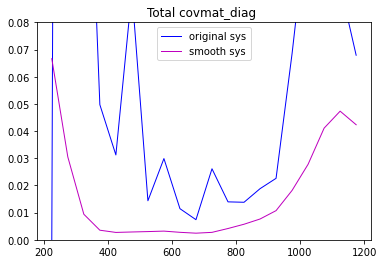

In [32]:
plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original sys')
plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth sys')
plt.legend()
plt.ylim([0,0.08])
plt.title('Total covmat_diag ')
print(cov_smooth.diagonal())

# Run 1

In [33]:
run = 'run1'
f_scaleslist = []
s_detsyslist = []
names = ['wiremodX','wiremodYZ','recomb','LYdown','SCE','wiremodThetaYZ','wiremodThetaXZ']#,'LYRayleigh']

for name in names:
    s_detsyslist.append(name)

#df_cv = pd.read_parquet('../../data/pickles/detsys_CV_run3_nodupesMay1.parquet')
#scaleCV = 9.65858292241e+19 

a_df_sys = []

i=0
for sys in s_detsyslist:
#    print('111')
    df_sys = pd.read_parquet('%s/pickles/%s_%s_%s.parquet'%(datafolder,sys,run,tag))
    print(df_sys.shape[0])
    i+=1
    a_df_sys.append(df_sys)
    print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))
#    print(df_sys.shape[0])


#####################################################
# For now add the run3 LYR###########################
#####################################################


names.append('LYRayleigh')
df_sys = pd.read_parquet('%s/pickles/LYRayleigh_run3_%s.parquet'%(datafolder,tag))

a_df_sys.append(df_sys)
print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))

#df_numu_run3_presel = pd.read_parquet('../../data/pickles/numu_run1_nodupesMay1.parquet')
#print((list(a_df_sys[7])))


71256
total 71256, cv = 58791 dv = 12465
71341
total 71341, cv = 58791 dv = 12550
13548
total 13548, cv = 6823 dv = 6725
13344
total 13344, cv = 6823 dv = 6521
13973
total 13973, cv = 6823 dv = 7150
70893
total 70893, cv = 58791 dv = 12102
70891
total 70891, cv = 58791 dv = 12100
total 71362, cv = 58791 dv = 12571


8
7
cv = 2382  and dv = 2382
cv POT = 609362734189999947776.000000 dv POT = 674276740521999990784.000000
cv[0] =  903.975952    cv[1] = 379.002136  rat = 0.704592
bwid = 203.766719 xmax-xmin=1000.000000  sum_cv = 2700.542845
[  1.00000101  13.9180754  101.74759733 156.21259645 165.19539313
 188.68592034 217.28213665 230.53444068 258.53796323 234.36273068
 214.28946802 211.04439367 159.11165658 123.84511583 135.65701667
  71.3191472   58.75615667  60.93995315  55.3106649   42.79241727]


<ipython-input-22-5a8fc8b0b81e>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-22-5a8fc8b0b81e>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-22-5a8fc8b0b81e>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-22-5a8fc8b0b81e>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


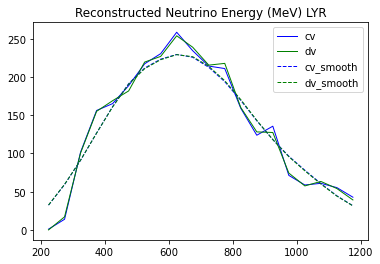

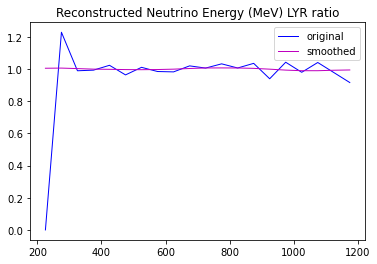

1       905.134338
2       373.617676
4       790.203186
7       581.098511
9       506.015747
           ...    
4755    887.785461
4756    447.338898
4759    343.097137
4761    666.778564
4763    618.055176
Name: Enu_1m1p, Length: 2382, dtype: float32

In [55]:
names = ['LYRayleigh']
for var in (['Enu_1m1p']):#,'Q3_1m1p','Q0_1m1p','Q2_1m1p']):
    plotfolder_tmp = plotfolder+'/'+var
    if not os.path.exists(plotfolder_tmp):
        os.makedirs(plotfolder_tmp)
        print(plotfolder_tmp)
    covfolder_tmp = covfolder+'/'+var

    if not os.path.exists(covfolder_tmp):
        os.makedirs(covfolder_tmp)
#    dist = varListSel['Enu_1m1p']
    
    dist = varListSel[var]
    nbins = dist.nbins

    cov = np.zeros((nbins,nbins))
    cov_smooth = np.zeros((nbins,nbins))

    
    print(len(a_df_sys))
#    for sysi in range(len(a_df_sys)): # loop over all detvars
    for sysi in range(1):
        sysi = 7
#        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        print(sysi)
        myvardf = myvardf_tmp#a_df_sys[sysi].query('Enu_1m1p > 0')
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts_cv)[dist.myname]
         
        print('cv = %d  and dv = %d'%(var_cv.shape[0],var_sys.shape[0]))

        pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
        pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
        print("cv POT = %f dv POT = %f"%(pot_cv,pot_dv))

        
        # get cv and detvar lists and apply weights
        var_cv_list = np.array(var_cv.astype(float).values.tolist())
        var_sys_list = np.array(var_sys.astype(float).values.tolist())
        cv_weights = np.array(myvardf.query(s_cuts_cv)['xsec_corr_weight'].astype(float).values.tolist())
        dv_weights = np.array(myvardf.query(s_cuts)['xsec_corr_weight'].astype(float).values.tolist())
        ratio = pot_cv / pot_dv

#        var_cv_list = var_cv_list * cv_weights 

#        var_sys_list = var_sys_list * sys_weights 
        
        
        
        CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],'LYR',cv_weights=cv_weights,dv_weights=dv_weights,nbin=nbins,ratio=1)
        #CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=1,dv_weights=1,nbin=nbins,ratio=ratio)

var_sys
#var_cv

In [51]:
var_sys = myvardf.query(s_cuts)
var_sys
#var_cv = myvardf.query(s_cuts_cv)
#var_cv
#overlap = var_cv.merge(var_sys[RSE],indicator = True, how='inner')[RSE]
#myvardf_tmp=myvardf.merge(overlap,how='inner')
#myvardf_tmp
#overlap

,bkgBDT_univ,Proton_CosTheta,Lepton_CosTheta,MPID_pion,MPID_gamma,MPID_proton,MPID_muon,MPID_eminus,PassPrecuts1m1p,run,...,isCV,POT,nu_interaction_mode,nu_interaction_type,xsec_corr_weight,spline_weight,nu_interaction_ccnc,nu_pdg,nu_energy_true,good
1,0.141891,0.604920,0.845922,0.887039,0.075891,0.875139,0.663768,0.734542,True,6527,...,False,6.742767e+20,1,1003,1.000000,1.0,0,14,1102.368951,1
2,0.141977,0.737868,0.547424,0.421866,0.016429,0.999613,0.893158,0.002501,True,7014,...,False,6.742767e+20,0,1002,1.000000,1.0,1,14,1086.055994,1
4,0.331493,0.708089,0.703010,0.666863,0.317639,0.907951,0.753914,0.339689,True,7054,...,False,6.742767e+20,1,1003,1.000000,1.0,0,14,1031.277418,1
7,0.369377,0.906699,-0.162842,0.000000,0.000000,0.000000,0.000000,0.000000,True,7026,...,False,6.742767e+20,0,1001,1.178639,1.0,0,14,582.669497,1
9,0.237816,0.365364,0.782276,0.249479,0.041695,0.984136,0.753195,0.023863,True,7026,...,False,6.742767e+20,0,1001,1.150606,1.0,0,14,499.050885,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,0.167203,0.413297,0.929418,0.265043,0.021776,0.914580,0.913110,0.003494,True,7010,...,False,6.742767e+20,0,1001,1.093414,1.0,0,14,868.279457,1
4756,0.348124,0.959954,-0.607085,0.754946,0.172178,0.537341,0.879200,0.046779,True,5341,...,False,6.742767e+20,0,1001,1.217677,1.0,0,14,742.081940,1
4759,0.250758,0.882979,-0.513095,0.416595,0.051497,0.992223,0.487772,0.051953,True,6122,...,False,6.742767e+20,1,1003,1.000000,1.0,0,14,694.815397,1
4761,0.362675,0.948886,-0.196844,0.413688,0.061090,0.997367,0.948568,0.021277,True,7012,...,False,6.742767e+20,0,1001,1.209218,1.0,0,14,672.998607,1


8
0
cv = 3759  and dv = 5476
cv POT = 898773223801000034304.000000 dv POT = 1309153192370000101376.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


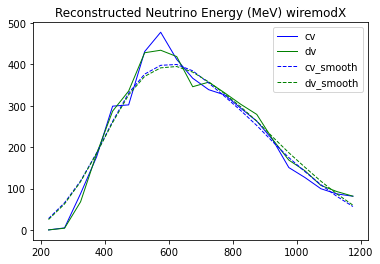

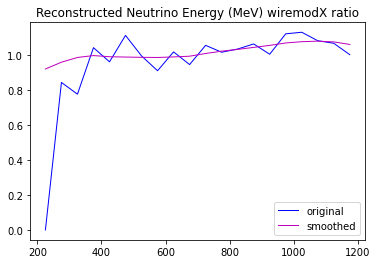

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4585.033794782068
4585.033852376463
Enu_1m1p [6.58027799e-03 1.79283133e-03 2.34013442e-04 1.98259945e-05
 1.24880419e-04 1.67200415e-04 2.09182415e-04 2.36189861e-04
 1.48661365e-04 6.60400543e-05 5.49104661e-05 4.24143055e-04
 9.48554681e-04 1.77755150e-03 2.88340878e-03 4.55270432e-03
 5.57524140e-03 6.05789450e-03 5.42321172e-03 3.47754086e-03]
Enu_1m1p [0.00000000e+00 2.49679068e-02 5.05503271e-02 1.65112816e-03
 1.61440395e-03 1.22616565e-02 4.18918594e-05 8.28685504e-03
 2.73095300e-04 3.12421662e-03 2.91203789e-03 2.14433546e-04
 1.07920128e-03 3.83800656e-03 9.72781078e-06 1.42989728e-02
 1.65647036e-02 6.45435578e-03 4.31138096e-03 4.11736741e-07]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


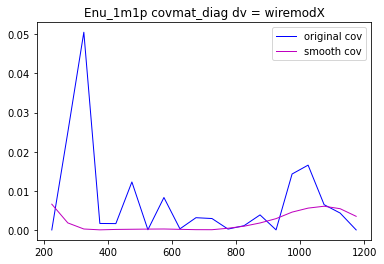

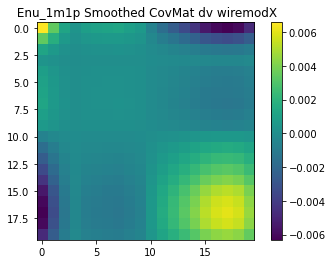

1
cv = 3759  and dv = 5541
cv POT = 898773223801000034304.000000 dv POT = 1310970606080000000000.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


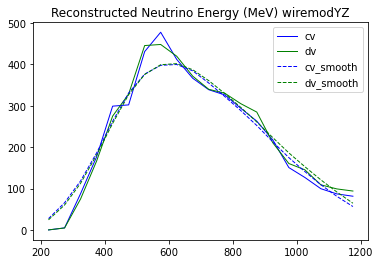

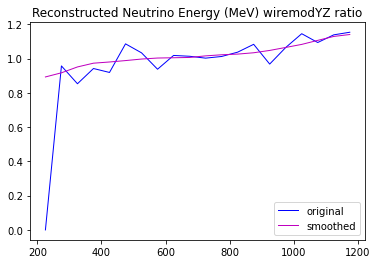

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4608.97371266023
4608.9737706481355
Enu_1m1p [1.14319306e-02 6.84717792e-03 2.35237476e-03 7.06257457e-04
 3.84377619e-04 1.29402165e-04 5.90247834e-06 1.20221967e-05
 2.66286242e-05 4.69133363e-05 2.58842051e-04 5.08784060e-04
 6.99915907e-04 1.17351271e-03 2.29253378e-03 4.26162732e-03
 6.90550180e-03 1.13683758e-02 1.67874637e-02 1.98300004e-02]
Enu_1m1p [0.00000000e+00 1.81457434e-03 2.15085622e-02 3.32922962e-03
 6.51129852e-03 7.45070755e-03 1.14450761e-03 3.82428062e-03
 3.46949227e-04 1.89920849e-04 8.17367872e-06 1.58227858e-04
 1.42837294e-03 6.98162356e-03 1.00870244e-03 4.21410540e-03
 2.11775586e-02 8.85398311e-03 1.92870584e-02 2.37312625e-02]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


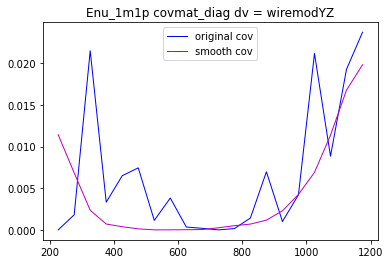

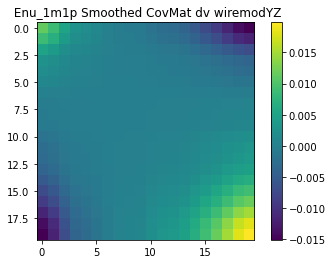

2
cv = 2779  and dv = 2737
cv POT = 609362734189999947776.000000 dv POT = 627484668519000047616.000000
cv[0] =  903.975952    cv[1] = 579.812805  rat = 0.609235
bwid = 199.321516 xmax-xmin=1000.000000  sum_cv = 3151.407550
[  1.00000101  18.0823598  135.38655836 190.1415413  193.88020482
 217.47738983 254.33047201 262.54723888 299.25861253 283.66247695
 249.8073354  235.32339911 187.39318659 139.76958964 148.98185661
  81.10056396  68.83619624  68.5251423   64.31786267  51.58556166]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


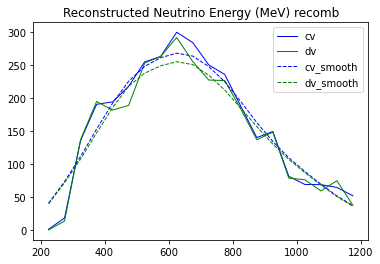

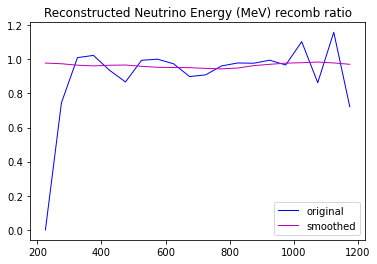

--------------------------  Hi There --------------------
3151.4075018753574
3151.407549665358
3022.244929060657
3022.244975640204
Enu_1m1p [0.00050161 0.00069361 0.00121147 0.00151876 0.00123709 0.00114388
 0.00171623 0.00221812 0.00234642 0.00243899 0.00286695 0.00318588
 0.00265838 0.00140103 0.00088902 0.00052071 0.00041313 0.00027475
 0.00046545 0.00087553]
Enu_1m1p [1.00000000e+00 6.50844446e-02 9.10927594e-05 5.03418592e-04
 4.14598917e-03 1.76906099e-02 3.73785803e-05 7.21367190e-08
 7.07483106e-04 1.02877959e-02 8.38940188e-03 1.52414951e-03
 4.80427858e-04 5.43145155e-04 3.20821067e-05 1.12303686e-03
 1.06296075e-02 1.89054604e-02 2.50275552e-02 7.72561496e-02]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


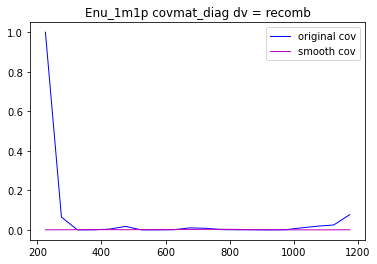

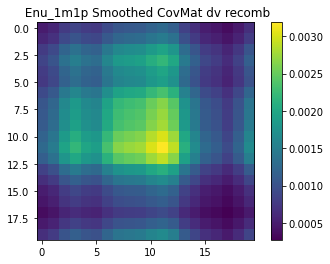

3
cv = 2779  and dv = 2674
cv POT = 609362734189999947776.000000 dv POT = 594452048285999955968.000000
cv[0] =  903.975952    cv[1] = 579.812805  rat = 0.609235
bwid = 199.321516 xmax-xmin=1000.000000  sum_cv = 3151.407550
[  1.00000101  18.0823598  135.38655836 190.1415413  193.88020482
 217.47738983 254.33047201 262.54723888 299.25861253 283.66247695
 249.8073354  235.32339911 187.39318659 139.76958964 148.98185661
  81.10056396  68.83619624  68.5251423   64.31786267  51.58556166]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


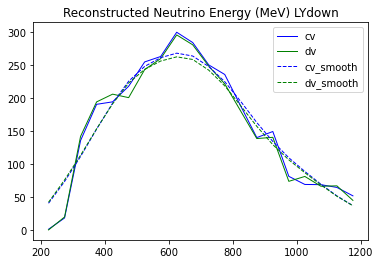

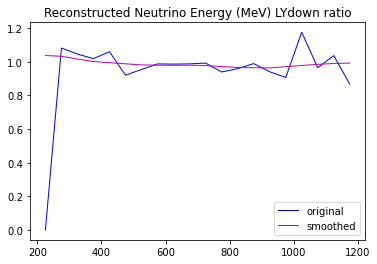

--------------------------  Hi There --------------------
3151.4075018753574
3151.407549665358
3097.701532900042
3097.7015803107643
Enu_1m1p [1.40083988e-03 1.10244063e-03 2.83685507e-04 4.23079378e-06
 2.90078808e-05 1.37439213e-04 3.29248378e-04 3.81579738e-04
 4.33049772e-04 3.91895340e-04 4.95891216e-04 7.87891062e-04
 1.14741459e-03 1.21953660e-03 1.31291908e-03 8.27671044e-04
 4.71818723e-04 2.26785531e-04 9.45206402e-05 5.31210203e-05]
Enu_1m1p [1.00000000e+00 6.75412905e-03 2.12864851e-03 3.71252750e-04
 3.61029700e-03 6.27808973e-03 2.07577276e-03 1.49315359e-04
 1.84027310e-04 1.46178807e-04 5.50705199e-05 3.62941076e-03
 1.66829350e-03 1.10579462e-04 3.49100983e-03 8.67720058e-03
 3.09978947e-02 1.20037137e-03 1.38309299e-03 1.76865646e-02]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


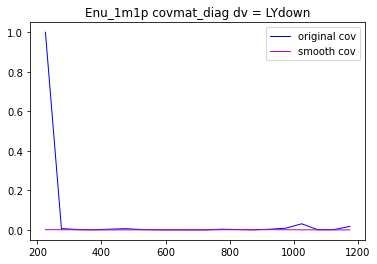

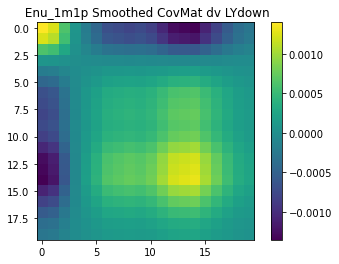

4
cv = 2779  and dv = 2937
cv POT = 609362734189999947776.000000 dv POT = 621993777142999941120.000000
cv[0] =  903.975952    cv[1] = 579.812805  rat = 0.609235
bwid = 199.321516 xmax-xmin=1000.000000  sum_cv = 3151.407550
[  1.00000101  18.0823598  135.38655836 190.1415413  193.88020482
 217.47738983 254.33047201 262.54723888 299.25861253 283.66247695
 249.8073354  235.32339911 187.39318659 139.76958964 148.98185661
  81.10056396  68.83619624  68.5251423   64.31786267  51.58556166]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


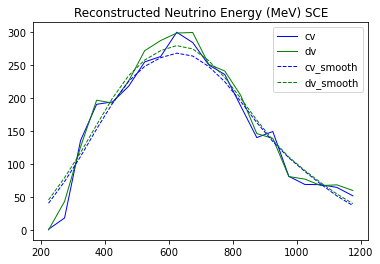

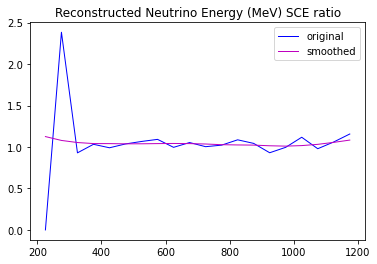

--------------------------  Hi There --------------------
3151.4075018753574
3151.407549665358
3269.8364521638587
3269.836500937434
Enu_1m1p [0.01577427 0.00625488 0.00289082 0.00170785 0.00166668 0.00146598
 0.00149075 0.00167883 0.00181939 0.00167695 0.0012939  0.00077286
 0.00060948 0.00051795 0.00021598 0.00011012 0.0002841  0.00101883
 0.00311749 0.0069507 ]
Enu_1m1p [1.00000000e+00 1.91496152e+00 4.99344338e-03 1.05528838e-03
 9.04209872e-05 1.36172913e-03 4.44527120e-03 8.45983634e-03
 1.67438155e-05 2.88618152e-03 1.37780588e-05 5.01153782e-04
 7.50071242e-03 1.88449488e-03 4.81290233e-03 1.54622160e-05
 1.37992350e-02 4.32584481e-04 3.69641497e-03 2.45674986e-02]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


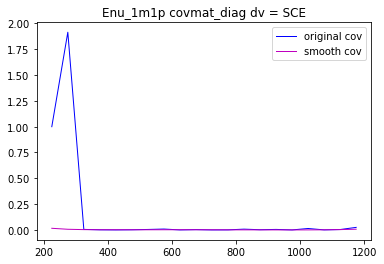

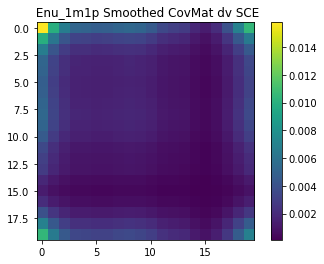

5
cv = 3759  and dv = 5313
cv POT = 898773223801000034304.000000 dv POT = 1264027045189999919104.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


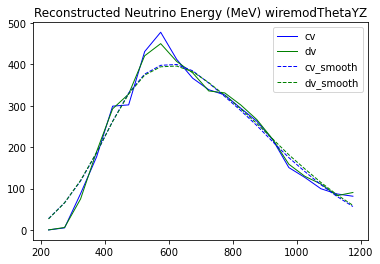

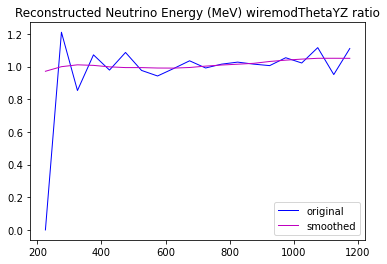

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4571.888883938484
4571.888941716018
Enu_1m1p [8.33630602e-04 5.43909444e-07 1.13015867e-04 5.30165019e-05
 3.27092524e-06 3.95050623e-05 4.09959001e-05 8.04741235e-05
 8.91550888e-05 3.29468442e-05 7.27528656e-06 8.90661814e-05
 2.08449115e-04 3.88608068e-04 9.68584956e-04 1.53679301e-03
 2.07991735e-03 2.55386185e-03 2.57807308e-03 2.54316695e-03]
Enu_1m1p [0.00000000e+00 4.41278062e-02 2.15291078e-02 5.13438176e-03
 4.65006262e-04 7.46155140e-03 5.57870251e-04 3.32573474e-03
 1.49723316e-04 1.24156507e-03 7.66425436e-05 2.18591218e-04
 7.38416889e-04 2.20263488e-04 3.33805598e-05 2.92245995e-03
 4.76554130e-04 1.34282916e-02 2.39859373e-03 1.21901267e-02]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


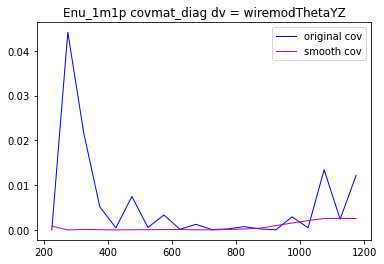

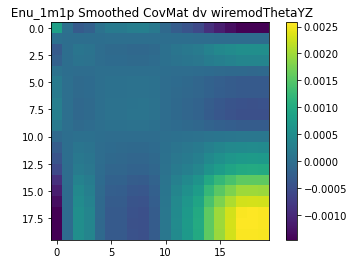

6
cv = 3759  and dv = 5357
cv POT = 898773223801000034304.000000 dv POT = 1296977725840000024576.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


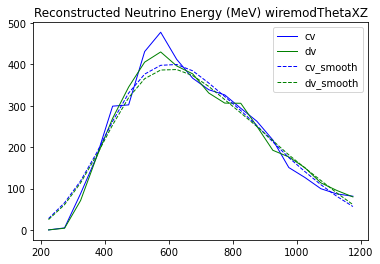

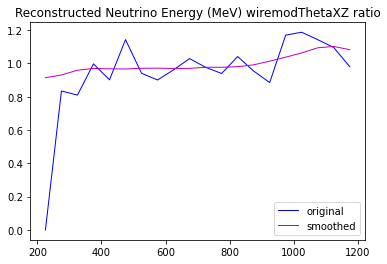

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4473.780447747171
4473.780504869845
Enu_1m1p [7.41985173e-03 4.84579943e-03 1.68651640e-03 9.02970731e-04
 1.06835158e-03 1.11609896e-03 8.67390773e-04 8.23801762e-04
 9.30277387e-04 9.00959283e-04 5.35272394e-04 5.44773355e-04
 3.85485769e-04 7.43839589e-05 1.84678634e-04 1.39126885e-03
 3.96211554e-03 8.77587451e-03 1.03634744e-02 6.75817929e-03]
Enu_1m1p [0.00000000e+00 2.74836364e-02 3.62185971e-02 7.59308538e-06
 9.73294739e-03 2.03676749e-02 3.50096495e-03 9.94011941e-03
 1.48090175e-03 8.30435409e-04 5.52783302e-04 3.68275833e-03
 1.69003973e-03 2.11787696e-03 1.32418193e-02 2.89191533e-02
 3.50031854e-02 2.03020137e-02 9.07973605e-03 3.88331268e-04]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


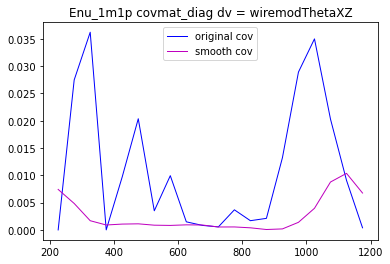

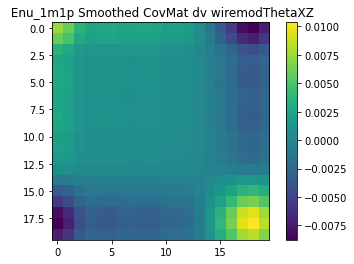

7
cv = 3759  and dv = 5578
cv POT = 898773223801000034304.000000 dv POT = 1308303170610000035840.000000
cv[0] =  400.276123    cv[1] = 1013.727722  rat = 0.283080
bwid = 189.197794 xmax-xmin=1000.000000  sum_cv = 4539.116944
[1.00000000e-06 4.90626091e+00 8.76207242e+01 1.76473407e+02
 2.98862073e+02 3.01921414e+02 4.30632621e+02 4.77338536e+02
 4.11806954e+02 3.66249178e+02 3.38586923e+02 3.26026700e+02
 2.93743616e+02 2.62596503e+02 2.17331076e+02 1.50575824e+02
 1.26685333e+02 9.94783798e+01 8.69226551e+01 8.13587653e+01]


<ipython-input-13-3c22a64d32b0>:87: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.7*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-13-3c22a64d32b0>:88: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print('bwid = %f xmax-xmin=%f  sum_cv = %f'%(bwid,xmax-xmin,sum(cv_hist)))
<ipython-input-13-3c22a64d32b0>:137: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-13-3c22a64d32b0>:150: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


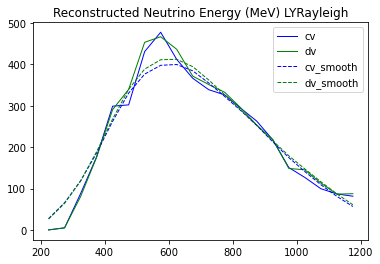

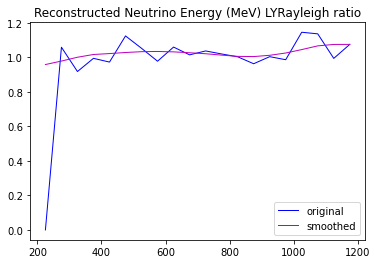

--------------------------  Hi There --------------------
4539.116886165633
4539.116943755636
4647.140742700829
4647.140801020366
Enu_1m1p [1.76664489e-03 4.76220756e-04 6.80458897e-08 2.62776325e-04
 4.62906230e-04 7.68183989e-04 1.05455639e-03 1.14482484e-03
 9.85065463e-04 6.91791737e-04 4.24144701e-04 1.57723716e-04
 2.81823247e-05 1.72267189e-05 1.32637273e-04 6.13522573e-04
 1.98827992e-03 4.37332071e-03 5.53939135e-03 5.56468150e-03]
Enu_1m1p [0.00000000e+00 3.40806961e-03 6.80850285e-03 3.66804980e-05
 7.70926366e-04 1.53225900e-02 2.71038812e-03 5.17229981e-04
 3.50426365e-03 1.98644151e-04 1.35413491e-03 3.71453687e-04
 8.33068361e-06 1.39703838e-03 1.32126122e-05 1.99386724e-04
 2.10488259e-02 1.84430196e-02 4.08718317e-05 5.59329441e-03]


<ipython-input-34-89ca0edc2086>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(hCV))
<ipython-input-34-89ca0edc2086>:76: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(CV_smooth))
<ipython-input-34-89ca0edc2086>:77: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(h0))
<ipython-input-34-89ca0edc2086>:78: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(DV_smooth))


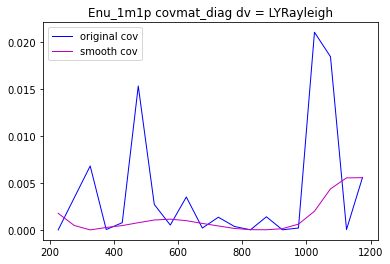

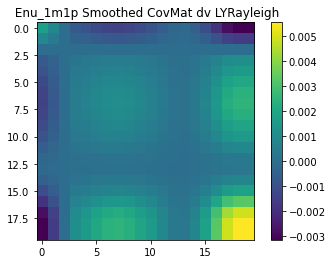

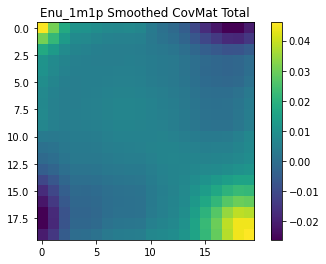

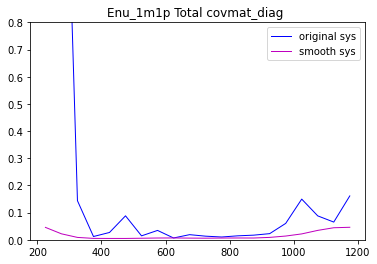

In [34]:


nbins = 20

if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)
if not os.path.exists(covfolder):
    os.makedirs(covfolder)

    
#for dist in varListSel: #[9:10]
#for _,dist in varListSel.items(): # loop over all variables 
#    var = dist.myname
    #for i in range():
for var in (['Enu_1m1p']):#,'Q3_1m1p','Q0_1m1p','Q2_1m1p']):
    plotfolder_tmp = plotfolder+'/'+var
    if not os.path.exists(plotfolder_tmp):
        os.makedirs(plotfolder_tmp)
        print(plotfolder_tmp)
    covfolder_tmp = covfolder+'/'+var

    if not os.path.exists(covfolder_tmp):
        os.makedirs(covfolder_tmp)
#    dist = varListSel['Enu_1m1p']
    
    dist = varListSel[var]
    nbins = dist.nbins

    cov = np.zeros((nbins,nbins))
    cov_smooth = np.zeros((nbins,nbins))

    
    print(len(a_df_sys))
    for sysi in range(len(a_df_sys)): # loop over all detvars
#    for sysi in range(1):
#        sysi = 3
#        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        print(sysi)
        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0')
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts_cv)[dist.myname]
        print('cv = %d  and dv = %d'%(var_cv.shape[0],var_sys.shape[0]))

        pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
        pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
        print("cv POT = %f dv POT = %f"%(pot_cv,pot_dv))

        
        # get cv and detvar lists and apply weights
        var_cv_list = np.array(var_cv.astype(float).values.tolist())
        var_sys_list = np.array(var_sys.astype(float).values.tolist())
        cv_weights = np.array(myvardf.query(s_cuts_cv)['xsec_corr_weight'].astype(float).values.tolist())
        dv_weights = np.array(myvardf.query(s_cuts)['xsec_corr_weight'].astype(float).values.tolist())
        ratio = pot_cv / pot_dv

#        var_cv_list = var_cv_list * cv_weights 

#        var_sys_list = var_sys_list * sys_weights 
        
        
        
        CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=cv_weights,dv_weights=dv_weights,nbin=nbins,ratio=ratio)
        #CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],cv_weights=1,dv_weights=1,nbin=nbins,ratio=ratio)
        np.save('%s/1Dhist_Enu_1m1p_run1_%s_CV_smooth.npy'%(histOut,names[sysi]), CV_smooth)
        np.save('%s/1Dhist_Enu_1m1p_run1_%s_DV_smooth.npy'%(histOut,names[sysi]), DV_smooth)

        
#        print(cv_weights)
        hCV,binedges = np.histogram(var_cv_list,bins=nbins,range=dist.myrange,weights= cv_weights)#cv_scale)
        h0,_ = np.histogram(var_sys_list,bins=nbins,range=dist.myrange,weights=dv_weights)#cv_scale)
        bincenters = np.diff(binedges)/2 + binedges[:-1] 
        h0 = h0 *ratio
        
        
        print('--------------------------  Hi There --------------------')
        print(sum(hCV))
        print(sum(CV_smooth))
        print(sum(h0))
        print(sum(DV_smooth))
    

        cov_tmp = np.zeros((nbins,nbins))
        cov_smooth_tmp = np.zeros((nbins,nbins))            
        for i in range(nbins):
            for j in range(nbins):
                if (hCV[i]*hCV[j])<1e-5:
                    cov_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
    #    print(dist.myname,cov.diagonal())
        for i in range(nbins):
            for j in range(nbins):
                if (CV_smooth[i]*CV_smooth[j])<1e-5:
                    cov_smooth_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_smooth_tmp[i][j] += (DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j])/(CV_smooth[i]*CV_smooth[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
        print(dist.myname,cov_smooth_tmp.diagonal())
        print(dist.myname,cov_tmp.diagonal())
        
        offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
        x= np.linspace(dist.myrange[0]+offset,dist.myrange[1]-offset,nbins)
        
        plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
        plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
        plt.legend()
        plt.title('%s covmat_diag dv = %s'%(dist.myname,names[sysi]))
        plt.savefig(plotfolder_tmp+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        
        plt.show()
        
        plt.imshow(cov_smooth_tmp, interpolation='none')
        plt.colorbar(orientation='vertical')
        plt.title(' %s Smoothed CovMat dv %s'%(dist.myname,names[sysi]))

        plt.savefig(plotfolder_tmp+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,names[sysi]), dpi=120,bbox_inches='tight')
        plt.show()

        cov = cov+ cov_tmp
        cov_smooth = cov_smooth + cov_smooth_tmp
        np.savetxt(covfolder_tmp+'/detsys_%s_%s_%s_cov.csv'%(dist.myname, run,names[sysi]),cov_smooth_tmp, delimiter=',')

    plt.imshow(cov_smooth, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.title('%s Smoothed CovMat Total'%dist.myname)

    plt.savefig(plotfolder_tmp+'/detsys_%s_%s_cov.png'%(dist.myname, run),dpi=120,bbox_inches='tight')

    plt.show()
    np.savetxt(covfolder_tmp+'/detsys_%s_%s_cov.csv'%(dist.myname, run),cov_smooth, delimiter=',')
    

    
    plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original sys')
    plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth sys')
    plt.legend()
    plt.ylim([0,0.8])
    plt.title('%s Total covmat_diag '%dist.myname)
    plt.savefig(plotfolder_tmp+'/Tot_sys_%s_%s_cov.png'%(dist.myname,run),dpi=120,bbox_inches='tight')



[0.04570905 0.02201351 0.00877197 0.00517569 0.00497656 0.00496769
 0.00571425 0.00657584 0.00677864 0.00624649 0.00593719 0.00647112
 0.00668586 0.0065698  0.00887976 0.01381442 0.0216801  0.03464969
 0.04436907 0.04605291]


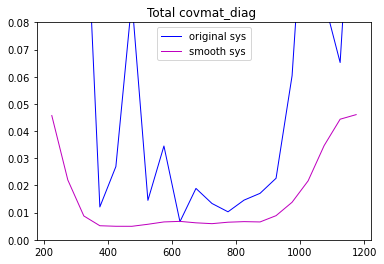

In [35]:
plt.plot(x,cov.diagonal(),linewidth=1, linestyle="-", c="b",label='original sys')
plt.plot(x,cov_smooth.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth sys')
plt.legend()
plt.ylim([0,0.08])
plt.title('Total covmat_diag ')
print(cov_smooth.diagonal())

Text(0.5, 1.0, 'Q2_1m1p Smoothed CovMat Total')

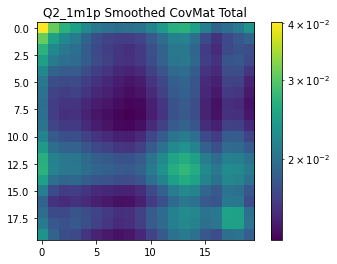

In [27]:
from matplotlib.colors import LogNorm

#f,ax = plt.subplots(1,1)
plt.imshow(cov_smooth, interpolation='none',norm=LogNorm())
plt.colorbar(orientation='vertical')
plt.title('%s Smoothed CovMat Total'%dist.myname)
plt.show()

wiremodX
6.767481725635091e-06
[1.05624516e-02 3.71392241e-03 1.01742918e-03 3.63174841e-04
 5.72340874e-04 5.92233991e-04 6.24672740e-04 6.79882706e-04
 5.39380110e-04 3.80114395e-04 1.61721776e-05 8.47465080e-05
 3.98223930e-04 1.08966308e-03 2.06828998e-03 3.54632915e-03
 4.43753687e-03 4.69534758e-03 4.06027909e-03 2.18184532e-03]


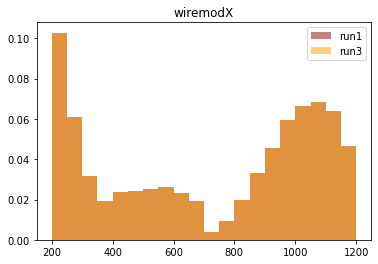

wiremodYZ
5.802018635080213e-05
[1.63198760e-02 1.01248650e-02 4.17105417e-03 1.67588550e-03
 1.04320327e-03 5.20638159e-04 1.70836706e-04 5.46554141e-05
 3.65840865e-05 2.19520849e-05 2.06127098e-05 1.23983989e-04
 2.44559498e-04 6.33413471e-04 1.57578822e-03 3.28536578e-03
 5.61877332e-03 9.43082998e-03 1.42239125e-02 1.63118601e-02]


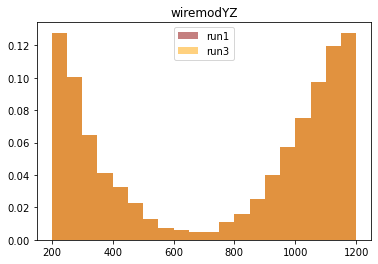

recomb
0.00033158060466039965
[9.75327382e-03 3.24361951e-03 5.43683867e-04 1.84094553e-05
 8.51966066e-05 4.58648643e-04 7.75047469e-04 7.21786900e-04
 3.12008132e-04 1.84111980e-05 7.87377379e-05 5.14613080e-04
 1.07861907e-03 1.31414768e-03 1.24477200e-03 1.28289579e-03
 1.09885849e-03 9.92153734e-04 7.81356133e-04 5.67558440e-04]


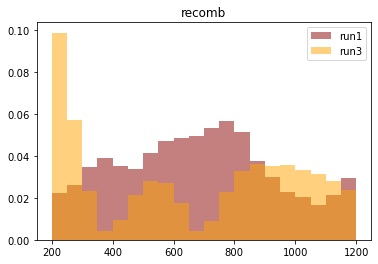

LYdown
0.0002444347496699101
[9.63467506e-03 5.56373004e-03 1.30576204e-03 3.67439560e-04
 2.17740603e-04 1.58742582e-04 1.65136430e-04 1.88463753e-04
 2.83486054e-04 4.40605613e-04 4.04510668e-04 4.17755835e-04
 2.93629985e-04 1.47620310e-04 5.92269507e-05 1.25540430e-05
 3.63202942e-04 7.80155015e-04 5.06459461e-04 1.35034130e-04]


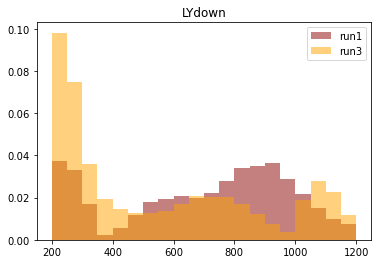

SCE
0.00017943981675736783
[1.36437621e-02 3.63859455e-03 1.56990326e-03 1.06017727e-03
 5.34286841e-04 1.95963374e-04 2.24870904e-05 2.93569880e-05
 1.58800351e-04 5.83590108e-04 1.24818816e-03 1.77406742e-03
 2.30899340e-03 2.89200305e-03 2.92412396e-03 3.51132224e-03
 3.62764778e-03 3.71408138e-03 3.21308862e-03 2.15577118e-03]


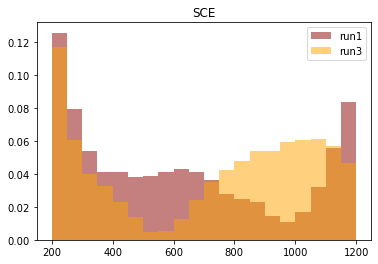

wiremodThetaYZ
1.5386665228824437e-06
[2.66235851e-03 4.03866293e-04 3.96867686e-05 5.60176096e-05
 2.15843216e-04 3.16412031e-04 2.90109862e-04 3.89115290e-04
 4.19833926e-04 2.92750855e-04 7.58121866e-05 3.41450738e-06
 1.40456495e-05 1.15974463e-04 5.33046230e-04 9.89728760e-04
 1.42518645e-03 1.71496041e-03 1.68948537e-03 1.47060402e-03]


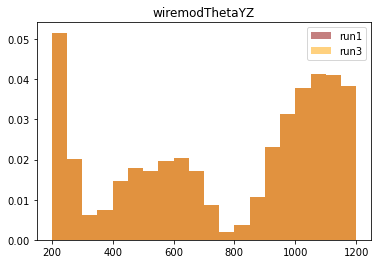

wiremodThetaXZ
0.00026859719922571376
[1.15310020e-02 7.69168559e-03 3.27675248e-03 1.96226403e-03
 2.04149367e-03 1.98838697e-03 1.58553828e-03 1.53802680e-03
 1.70808999e-03 1.69122497e-03 1.17038228e-03 1.17373554e-03
 9.01577552e-04 3.01193000e-04 3.22495888e-05 8.74695959e-04
 3.03356381e-03 7.11633942e-03 8.39372048e-03 4.85181856e-03]


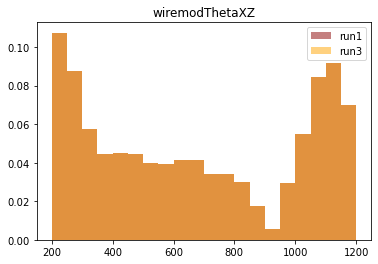

LYRayleigh
0.0001250841503952704
[4.13261505e-03 1.66565559e-03 2.75245110e-04 1.49208089e-06
 6.87234890e-05 2.50346656e-04 4.60675379e-04 5.13372508e-04
 3.96048900e-04 2.12013197e-04 8.09183222e-05 1.49658365e-06
 2.82408460e-05 2.21403063e-05 1.27290382e-05 2.92838885e-04
 1.35490692e-03 3.24659488e-03 4.16999555e-03 3.87019095e-03]


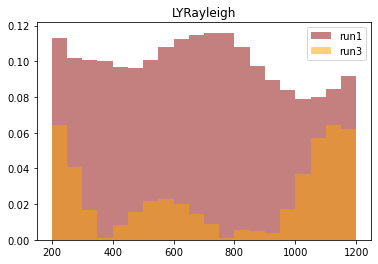

0.0014242704757110292
[0.09203467 0.04573467 0.01659256 0.00684007 0.00516796 0.00460771
 0.00411195 0.00411534 0.00386224 0.00381658 0.00343963 0.00443017
 0.00550049 0.00661945 0.00845493 0.0142927  0.02219156 0.03287441
 0.03797567 0.03186277]


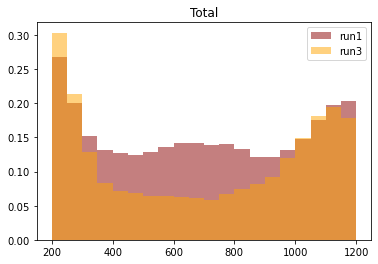

In [28]:
from numpy import genfromtxt

for sysi in range(len(a_df_sys)):
#for sysi in range(1):
    print(names[sysi])
    run3 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run3_%s_cov.csv'%names[sysi], delimiter=',')
    run1 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run1_%s_cov.csv'%names[sysi], delimiter=',')
    #print(np.average(run1))
    print(np.average(run3))


    #print(run1.diagonal())
    print(run3.diagonal())
    plt.bar(x, np.sqrt(run1.diagonal()), width = 50,
            color = 'darkred', linewidth = 0, alpha = 0.5,label="run1")
    plt.bar(x, np.sqrt(run3.diagonal()), width = 50,
            color = 'orange', linewidth = 0, alpha = 0.5,label="run3")
    plt.legend()
    plt.title(names[sysi])
    plt.show()
#print(np.sqrt(run3.diagonal()))
#bla = run3-run1
#print(100*bla.diagonal()/run3.diagonal())

run3 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run3_cov.csv', delimiter=',')
run1 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run1_cov.csv', delimiter=',')
#print(np.average(run1))
print(np.average(run3))


#print(run1.diagonal())
print(run3.diagonal())
plt.bar(x, np.sqrt(run1.diagonal()), width = 50,
        color = 'darkred', linewidth = 0, alpha = 0.5,label="run1")
plt.bar(x, np.sqrt(run3.diagonal()), width = 50,
        color = 'orange', linewidth = 0, alpha = 0.5,label="run3")
plt.legend()
plt.title('Total')
plt.show()

wiremodX
-3.350800393342968e-05
[ 0.01842157  0.00859834  0.00189521  0.00111419  0.00060856  0.00053494
  0.0005942   0.00056564  0.00049152  0.00037589  0.00012198 -0.00015306
 -0.00012234  0.00030968  0.00093974  0.00190481  0.00287053  0.0035426
  0.00308907  0.00101035]


<ipython-input-14-8da765d944c4>:17: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x, np.sqrt(run1.diagonal()), width = 50,
<ipython-input-14-8da765d944c4>:19: RuntimeWarning: invalid value encountered in sqrt
  plt.bar(x, np.sqrt(run3.diagonal()), width = 50,


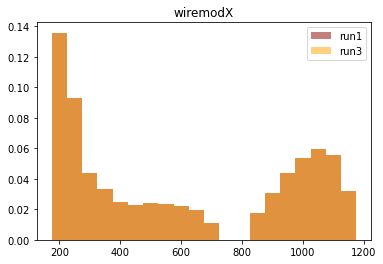

wiremodYZ
-2.416012790858716e-05
[ 8.60260270e-03  1.27385986e-02  6.05443281e-03  3.25262814e-03
  1.57769800e-03  7.93836477e-04  3.53760591e-04  1.30356362e-04
  4.22694373e-05  8.53679238e-06 -1.78176062e-05 -1.77012901e-05
  9.35458816e-05  3.48502481e-04  7.56472371e-04  1.60457616e-03
  3.01497693e-03  4.68779529e-03  5.33550479e-03  3.59382197e-03]


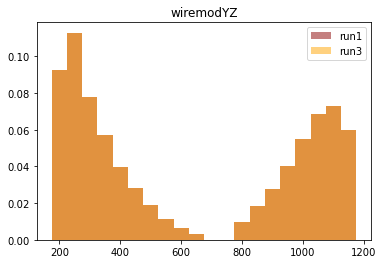

recomb
0.00022711912239799974
[ 9.45245394e-04  5.77061267e-03  1.34659361e-03  9.07018574e-05
 -1.71984928e-04 -3.85024627e-05  2.27827463e-04  4.32412725e-04
  3.21198407e-04  7.39519597e-05 -1.32266896e-04 -6.71749058e-05
  2.82596446e-04  7.66022200e-04  1.15070328e-03  1.46050653e-03
  1.08695565e-03  5.93823117e-04  4.12816444e-07 -2.41659111e-04]


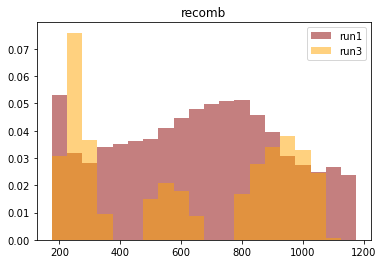

LYdown
0.00044871784670744933
[ 1.54159322e-02  6.90286454e-03  2.46465114e-03  1.08478412e-03
  4.06866037e-04  2.49382579e-04  1.94351394e-04  1.72985356e-04
  1.83645532e-04  2.43852925e-04  2.92499300e-04  3.64654546e-04
  3.15224753e-04  1.89666611e-04  8.61062267e-05 -3.04350787e-05
 -7.83700111e-05  5.10900822e-05  9.80184613e-05 -1.83100415e-04]


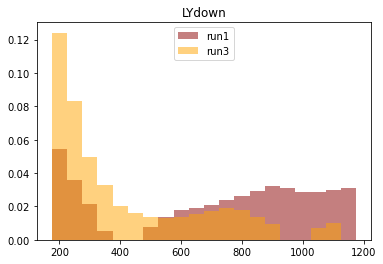

SCE
-1.1990811370199003e-05
[ 1.09382725e-02  6.21867177e-03  3.40042817e-03  1.28227480e-03
  6.92563221e-04  3.08336778e-04  3.50672193e-05 -9.36028608e-05
 -3.03454053e-05  2.10896208e-04  5.96082312e-04  1.06153599e-03
  1.78128532e-03  2.39442560e-03  2.84017671e-03  3.36366612e-03
  3.07271271e-03  2.26148166e-03  1.11285236e-03  9.49416312e-05]


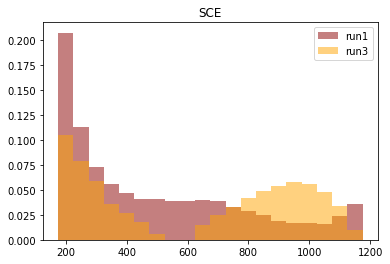

wiremodThetaYZ
1.6326363126470007e-06
[ 1.72782861e-03  1.35581167e-03  1.52126490e-04  1.44751130e-04
  7.26107844e-05  1.68949656e-04  2.38210629e-04  2.94787573e-04
  2.84412491e-04  2.80493723e-04  1.66581009e-04  1.02653459e-05
 -4.86777615e-05 -7.07906247e-06  1.18177996e-04  3.45416077e-04
  8.29412313e-04  1.20286351e-03  8.25807853e-04 -5.33369032e-05]


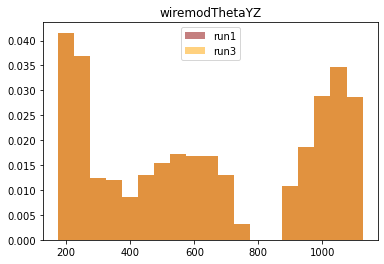

wiremodThetaXZ
0.0005127420152909616
[ 0.01141608  0.01021022  0.00486202  0.00358878  0.00231057  0.00203631
  0.00183771  0.00173782  0.00156734  0.00155697  0.0014787   0.00130783
  0.00097136  0.00051248 -0.00011844 -0.00043215  0.00021669  0.00186796
  0.00339638  0.00312401]


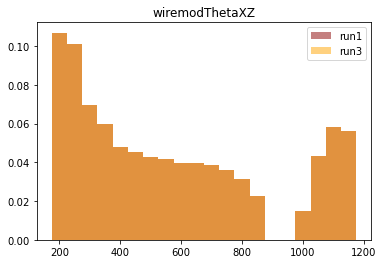

LYRayleigh
-4.640943932851062e-06
[ 5.90122742e-03  2.61606832e-03  4.23509016e-04 -1.30803688e-04
 -8.45517054e-05  6.95078957e-05  2.26286495e-04  3.85192264e-04
  4.56905241e-04  3.65528218e-04  1.92475672e-04  6.51650503e-05
 -1.19070013e-05 -4.00168649e-06 -8.90485083e-06 -1.81146540e-05
  2.20482867e-04  7.80652217e-04  1.14928876e-03  7.04290294e-04]


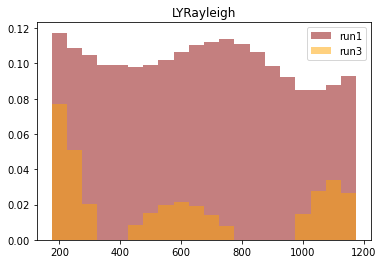

0.0014764724312441337
[0.0800232  0.06482902 0.02646357 0.01301767 0.00634902 0.0044598
 0.0037823  0.00362051 0.00332616 0.00311143 0.00273207 0.00273597
 0.00344672 0.00461532 0.0057361  0.00806748 0.01130582 0.0154577
 0.01505132 0.0075397 ]


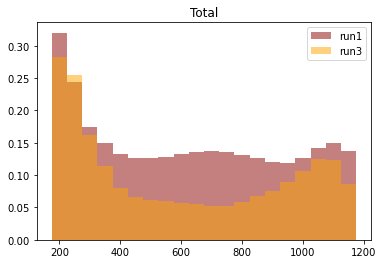

In [14]:
from numpy import genfromtxt
x= np.arange(200,1200,50)
for sysi in range(len(a_df_sys)):
#for sysi in range(1):
    print(names[sysi])
    run3 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run3_%s_cov.csv'%names[sysi], delimiter=',')
    run1 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run1_%s_cov.csv'%names[sysi], delimiter=',')
    run3 = run3[2:]
    run1 = run1[2:]

    #print(np.average(run1))
    print(np.average(run3))


    #print(run1.diagonal())
    print(run3.diagonal())
    plt.bar(x, np.sqrt(run1.diagonal()), width = 50,
            color = 'darkred', linewidth = 0, alpha = 0.5,label="run1")
    plt.bar(x, np.sqrt(run3.diagonal()), width = 50,
            color = 'orange', linewidth = 0, alpha = 0.5,label="run3")
    plt.legend()
    plt.title(names[sysi])
    plt.show()
#print(np.sqrt(run3.diagonal()))
#bla = run3-run1
#print(100*bla.diagonal()/run3.diagonal())

run3 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run3_cov.csv', delimiter=',')
run1 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-02-24/Enu_1m1p/detsys_Enu_1m1p_run1_cov.csv', delimiter=',')
run3 = run3[2:]
run1 = run1[2:]
#print(np.average(run1))
print(np.average(run3))


#print(run1.diagonal())
print(run3.diagonal())
plt.bar(x, np.sqrt(run1.diagonal()), width = 50,
        color = 'darkred', linewidth = 0, alpha = 0.5,label="run1")
plt.bar(x, np.sqrt(run3.diagonal()), width = 50,
        color = 'orange', linewidth = 0, alpha = 0.5,label="run3")
plt.legend()
plt.title('Total')
plt.show()

In [31]:
dvar = varListSel['Xreco']
nbins = 14
cov = np.zeros((nbins,nbins))
flatsys = 0.0

for sysi in range(len(a_df_sys)):
    myvardf = a_overlap_sys[sysi].query(s_cuts)
    myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
    var_sys = myvardf[dvar.myname]
    var_cv = myvarcv[dvar.myname+'_cv']
          
    hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
    h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
    bincenters = np.diff(binedges)/2 + binedges[:-1]
        
    # polyfit
    polyterms = 4
    polyCV = np.polyfit(bincenters, hCV, polyterms)
    fCV = np.poly1d(polyCV)    
    poly0 = np.polyfit(bincenters, h0, polyterms)
    f0 = np.poly1d(poly0)    
    
    hCV_fit = fCV(bincenters)
    h0_fit = f0(bincenters)
    
    #Savitsky Golay
    window_length = 7
    little_poly_t = 3
    hCV_sgfit = signal.savgol_filter(hCV, window_length, little_poly_t)
    h0_sgfit = signal.savgol_filter(h0, window_length, little_poly_t)
        
    
    fig,ax = plt.subplots(figsize=(16,11))
        
    dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
    #plt.plot(dvarLinspace,fCV(dvarLinspace),label='CV Fit (%f)'%chi2_cv)
    #plt.plot(dvarLinspace,f0(dvarLinspace),label='Variation Fit (%f)'%chi2_h0)
    #plt.scatter(bincenters,hCV_sgfit,label='CV SG Fit (%f)'%chi2_cv_sgfit,marker='o',s=120)
    #plt.scatter(bincenters,h0_sgfit,label='Variation SG Fit (%f)'%chi2_h0_sgfit,marker='o')
    ax.set_title(s_detsyslist[sysi],fontsize=30)
    ax.set_xlabel(dvar.mylabel,fontsize=20)
    ax.legend(fontsize=15)
    
    
    for i in range(nbins):
        for j in range(nbins):
            cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
            #cov[i][j] += (h0_fit[i]-hCV_fit[i])*(h0_fit[j]-hCV_fit[j])/(hCV_fit[i]*hCV_fit[j])
            #cov[i][j] += (h0_sgfit[i]-hCV_sgfit[i])*(h0_sgfit[j]-hCV_sgfit[j])/(hCV_sgfit[i]*hCV_sgfit[j])
    flatsys += np.power(h0.sum()-hCV.sum(),2)/float(h0.sum()*hCV.sum())
            
            
print('flat sys:',np.sqrt(flatsys),flatsys)
print(dvar.myname,cov[0][0],cov[7][7])
X, Y = np.meshgrid(binedges,binedges)

fig,ax = plt.subplots(figsize=(10,10))
crat = ax.pcolormesh(X, Y,cov.T,cmap='cool')#,vmin=-2,vmax=3)
cbar = fig.colorbar(crat)
ax.set_title('Fractional Covariance Matrix',fontsize=30)
ax.set_ylabel(dvar.mylabel,fontsize=20)
ax.set_xlabel(dvar.mylabel,fontsize=20)
#np.savetxt('/home/dcianci/Downloads/detsys_enu_sgfit_cov.csv',cov,delimiter=',')

#cov = np.zeros((nbins,nbins))
#for i in range(nbins):
#    cov[i][i] = flatsys
#np.savetxt('/home/dcianci/Downloads/detsys_enu_flat_cov.csv',cov,delimiter=',')



NameError: name 'a_overlap_sys' is not defined

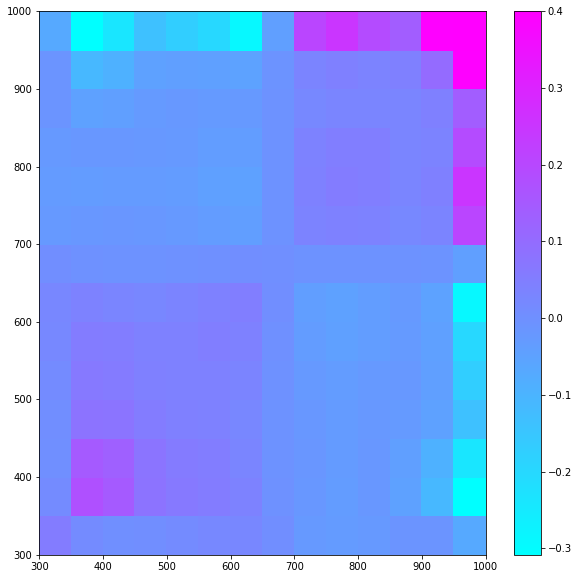

In [138]:
X, Y = np.meshgrid(binedges,binedges)

fig,ax = plt.subplots(figsize=(10,10))
crat = ax.pcolormesh(X, Y,cov,cmap='cool',vmax=.4)
cbar = fig.colorbar(crat)


In [59]:
list(df_sys)

['Proton_CosTheta_cv',
 'Lepton_CosTheta_cv',
 'Proton_CosTheta',
 'Lepton_CosTheta',
 'bkgBDT_run3_cv',
 'bkgBDT_run3',
 'run',
 'subrun',
 'event',
 'vtxid',
 'Xreco',
 'Yreco',
 'Zreco',
 'InFiducial',
 'AnyReco',
 'NTracks',
 'N5cmTracks',
 'PassSimpleCuts',
 'PassShowerReco',
 'PassSecondShower',
 'FailedBoost',
 'FailedBoost_1m1p',
 'FailedBoost_1e1p',
 'Good3DReco',
 'Eta',
 'OpenAng',
 'Thetas',
 'Phis',
 'QCorrectionFactorVertex',
 'ChargeNearTrunk',
 'LongTrackLen',
 'ShortTrackLen',
 'MaxShrFrac',
 'MinShrFrac',
 'CCQEEnergyShift_1m1p',
 'Enu_1m1p',
 'PhiT_1m1p',
 'AlphaT_1m1p',
 'PT_1m1p',
 'PTRat_1m1p',
 'BjX_1m1p',
 'BjY_1m1p',
 'Q2_1m1p',
 'Sph_1m1p',
 'PzEnu_1m1p',
 'Q0_1m1p',
 'Q3_1m1p',
 'OpenAngB_1m1p',
 'ThetasB_1m1p',
 'PhisB_1m1p',
 'PhiTB_1m1p',
 'AlphaTB_1m1p',
 'PTB_1m1p',
 'BjXB_1m1p',
 'BjYB_1m1p',
 'Q2B_1m1p',
 'SphB_1m1p',
 'CCQEEnergyShift_1e1p',
 'Enu_1e1p',
 'PhiT_1e1p',
 'AlphaT_1e1p',
 'PT_1e1p',
 'PTRat_1e1p',
 'BjX_1e1p',
 'BjY_1e1p',
 'Q2_1e1p',
 'S

wiremodX
polyfit degrees: 0 7.19169553120931
sg window_length 7 degrees: 10 7.116065343221028
wiremodYZ
polyfit degrees: 0 14.652654012044271
sg window_length 7 degrees: 10 14.726931889851889
wiremoddEdx
polyfit degrees: 0 8.301823933919271
sg window_length 1 degrees: 10 8.199064095815023
LYdown
polyfit degrees: 0 5.715118010838826
sg window_length 9 degrees: 10 5.694827159245809
SCE
polyfit degrees: 0 14.362505276997885
sg window_length 9 degrees: 10 14.273023923238119
wiremodThetaYZ
polyfit degrees: 0 6.244710286458333
sg window_length 11 degrees: 10 6.2069681485493975
wiremodThetaXZ
polyfit degrees: 0 10.961923917134603
sg window_length 3 degrees: 10 10.499676068623861
flat sys: 0.08959695735944827 0.008027614768070792


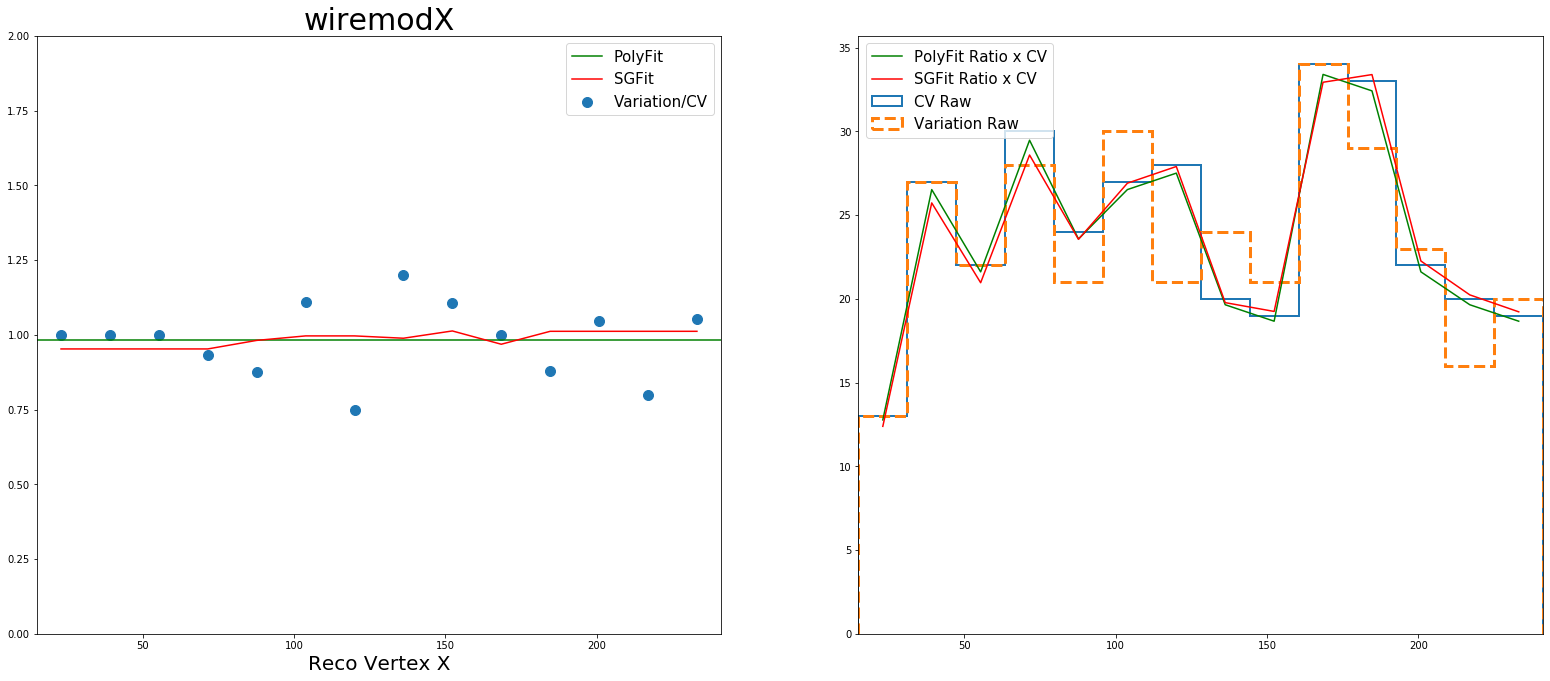

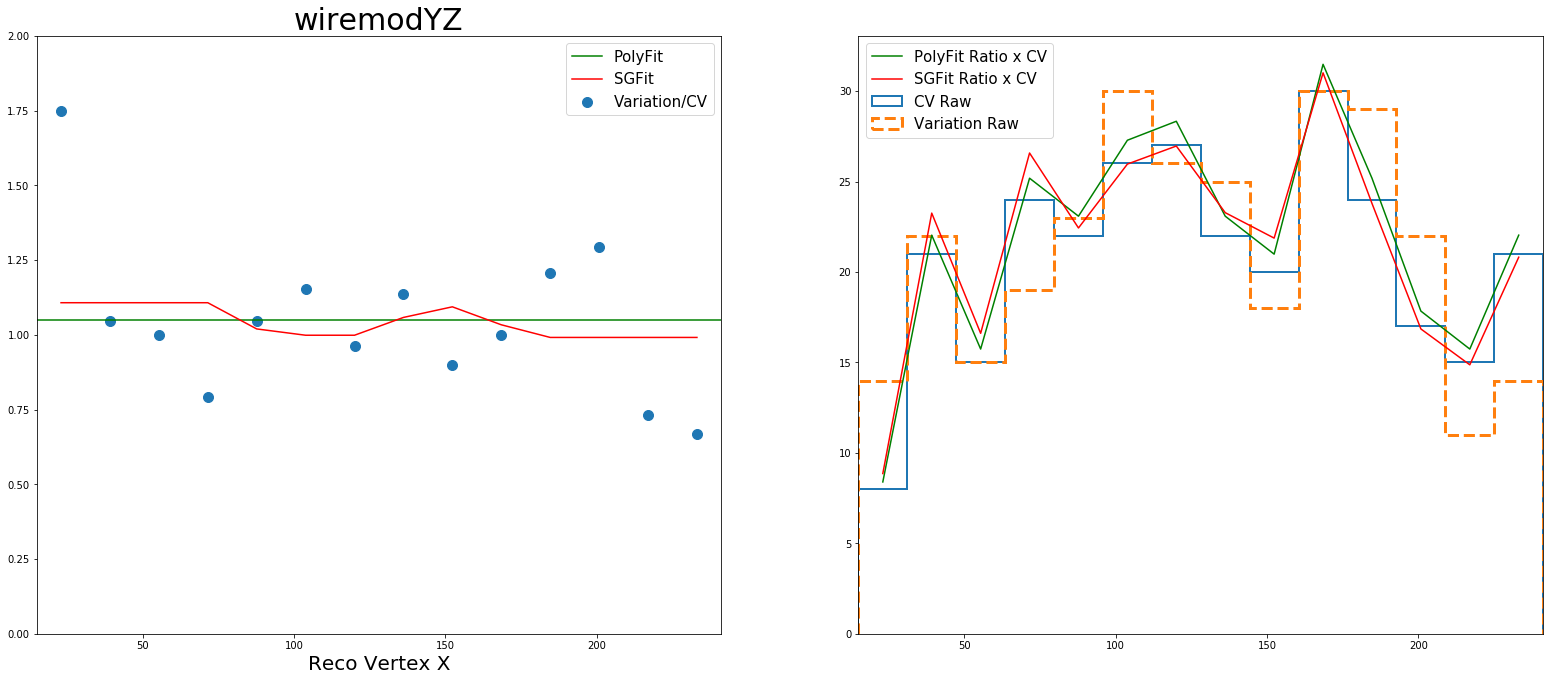

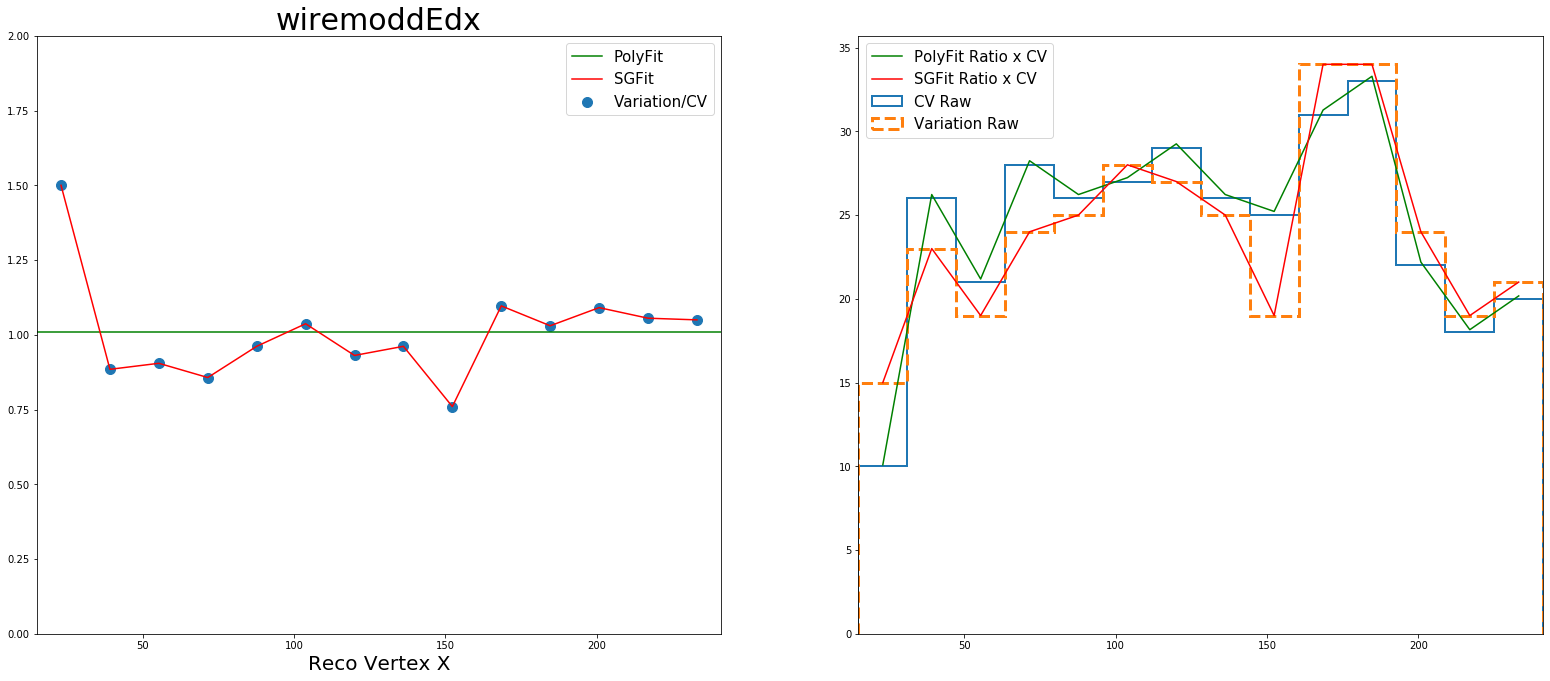

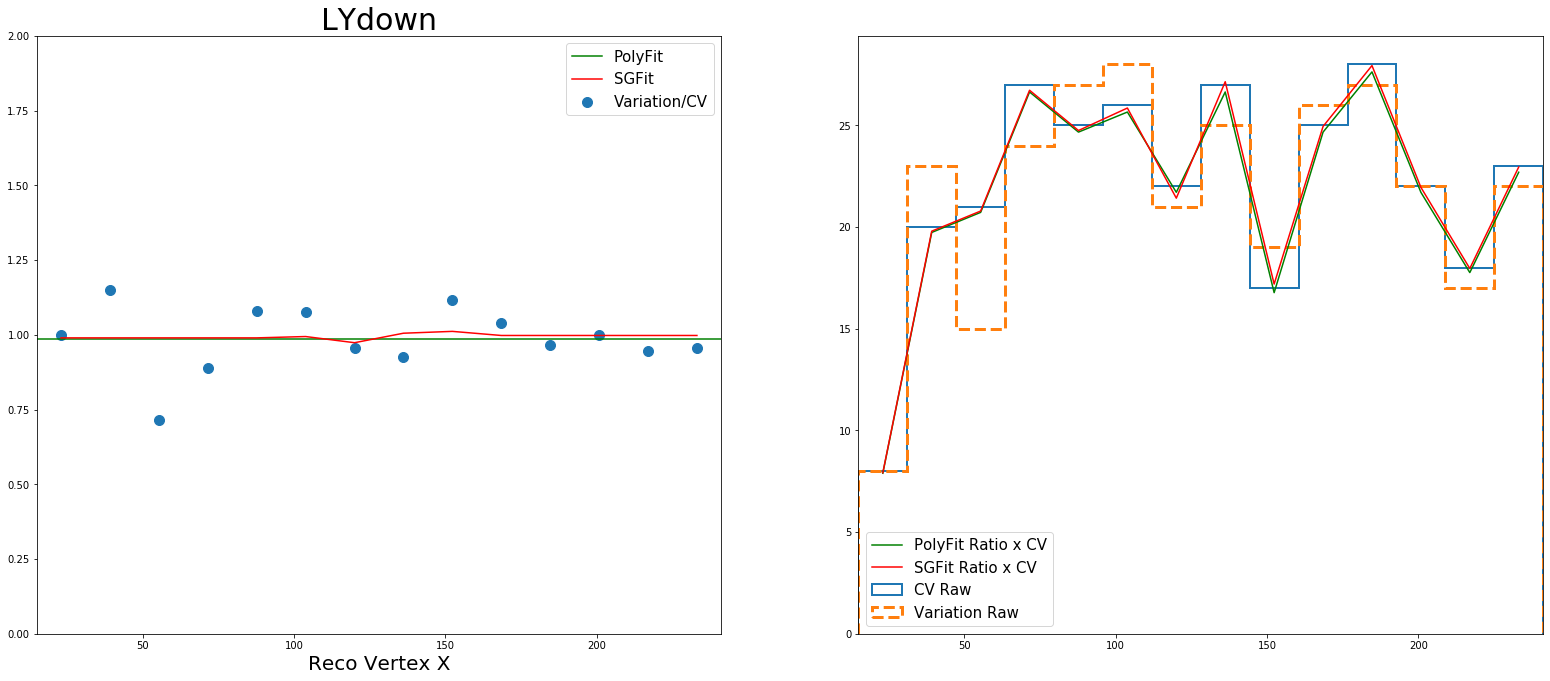

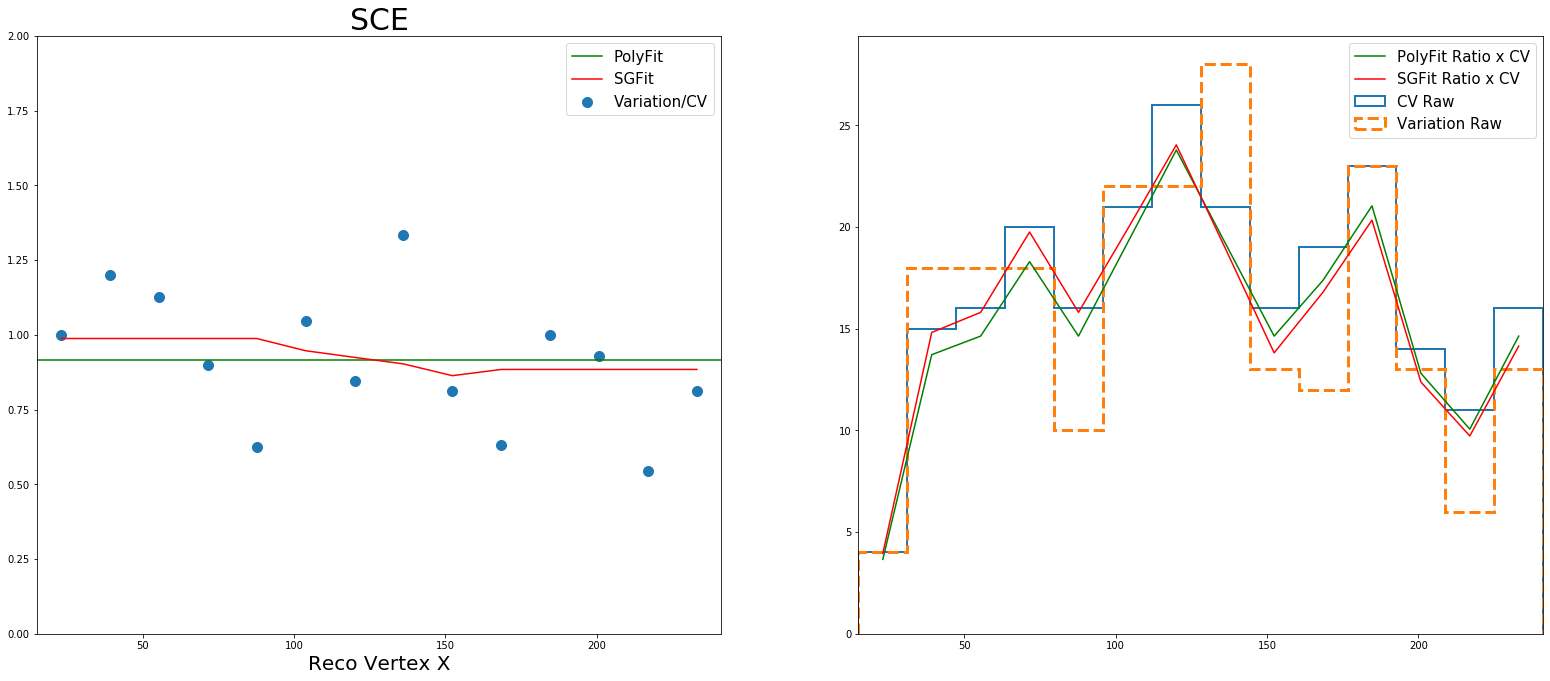

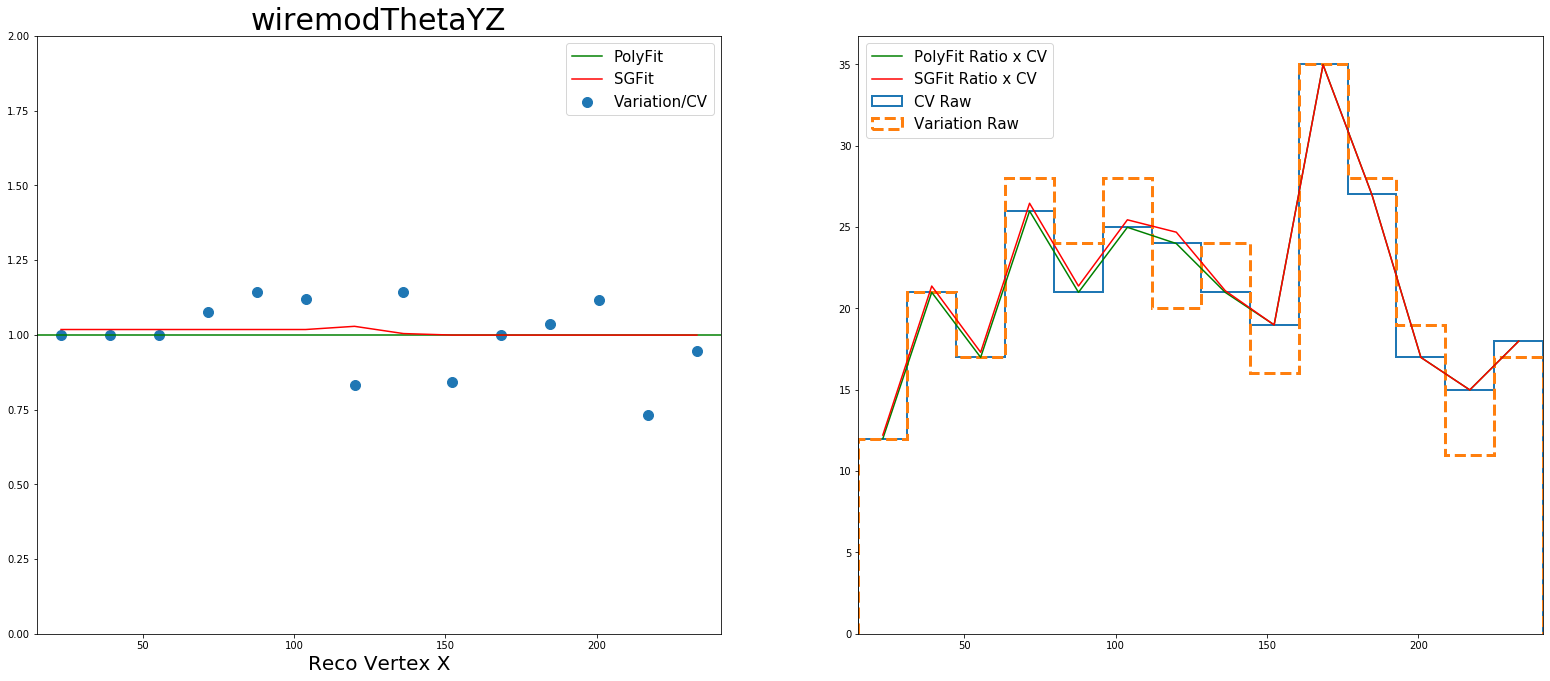

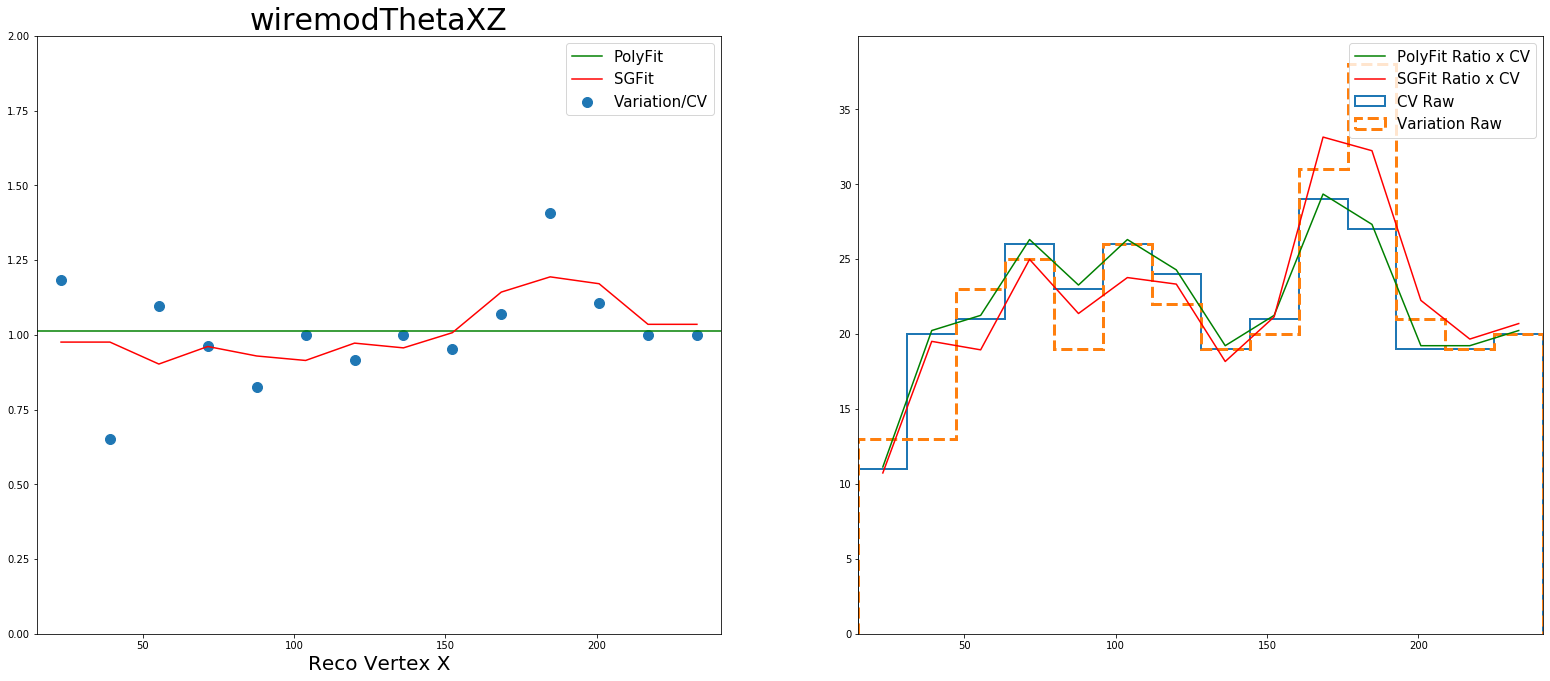

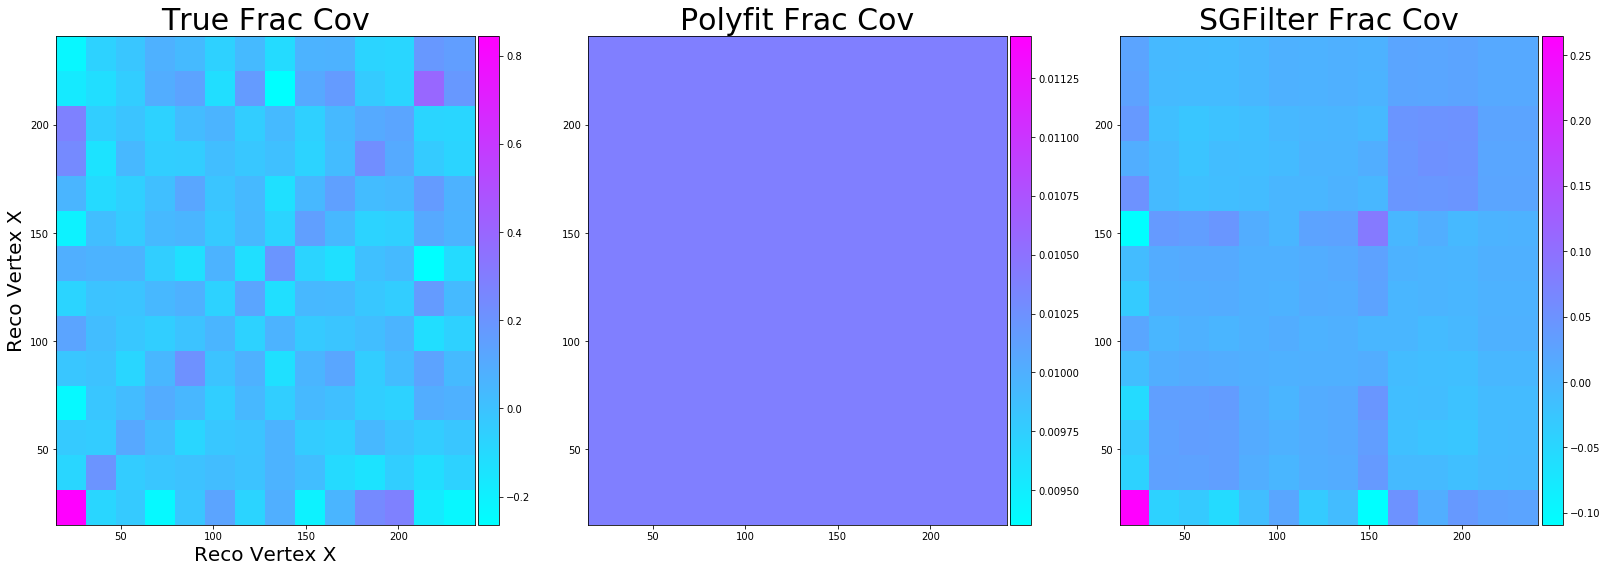

In [153]:
# The same thing with ratios

dvar = varListSel['Xreco']
nbins = 14
cov_tru = np.zeros((nbins,nbins))
cov_poly = np.zeros((nbins,nbins))
cov_sg = np.zeros((nbins,nbins))
flatsys = 0.0

for sysi in range(len(a_df_sys)):
    print(s_detsyslist[sysi])
    myvardf = a_overlap_sys[sysi].query(s_cuts)
    myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
    var_sys = myvardf[dvar.myname]
    var_cv = myvarcv[dvar.myname+'_cv']
          
    hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
    h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    truRat = np.true_divide(h0,hCV,out=np.ones_like(bincenters),where=hCV!=0)
      
    # get polyfit degs
    aics = []
    degs = []
    for deg in range(min(nbins-2,int(nbins/2))):
        params = deg + 1
        polyRat = np.polyfit(bincenters, truRat, deg)
        fRat = np.poly1d(polyRat)
    
        # now calculate chi2 for fit
        yerr_rat = np.true_divide(np.sqrt(fRat(bincenters)*hCV),hCV,out=np.zeros_like(bincenters),where=hCV!=0)
        chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat),2).sum()
        aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
        aics.append(aic)
        degs.append(deg)
      
    polyterms = degs[np.argmin(aics)]
    print('polyfit degrees:',polyterms,aics[np.argmin(aics)])  
    polyRat = np.polyfit(bincenters, np.true_divide(h0,hCV,where=hCV!=0), polyterms)
    fRat = np.poly1d(polyRat) 
    h0_fit = fRat(bincenters)*hCV
    
    # get sg degs
    aics = []
    degs = []
    wls = []
    for window_length in range(1,nbins-1,2):
        for deg in range(window_length):   
            params = deg + 1
            sgRat = signal.savgol_filter(np.true_divide(h0,hCV,where=hCV!=0), window_length, deg)
            
            # now calculate chi2 for fit
            yerr_rat = np.true_divide(np.sqrt(sgRat*hCV),hCV,out=np.zeros_like(bincenters),where=hCV!=0)
             
            chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat,out=np.zeros_like(bincenters),where=yerr_rat!=0),2).sum()
            aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
            aics.append(aic)
            degs.append(deg)
            wls.append(window_length)
           
    #Savitsky Golay
    window_length = wls[np.argmin(aics)]
    little_poly_t = degs[np.argmin(aics)]
    print('sg window_length',window_length,'degrees:',deg,aics[np.argmin(aics)])
    sgRat = signal.savgol_filter(np.true_divide(h0,hCV,where=hCV!=0), window_length, little_poly_t)
    h0_sgfit = sgRat*hCV
        
    fig,ax = plt.subplots(figsize=(27,11))    
    gs = gridspec.GridSpec(1, 2)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
    ax0.scatter(bincenters,np.true_divide(h0,hCV,where=hCV!=0),label='Variation/CV',s=100)
    ax0.plot(dvarLinspace,fRat(dvarLinspace),label='PolyFit',color='green')
    ax0.plot(bincenters,sgRat,label='SGFit',color='red')
    
    ax0.set_title(s_detsyslist[sysi],fontsize=30)
    ax0.set_xlabel(dvar.mylabel,fontsize=20)
    ax0.legend(fontsize=15)
    
    ax1.hist(var_cv,nbins,range=dvar.myrange,histtype='step',linewidth=2,label='CV Raw')
    ax1.hist(var_sys,nbins,range=dvar.myrange,histtype='step',linewidth=3,linestyle='--',label='Variation Raw')
    ax1.plot(bincenters,h0_fit,label='PolyFit Ratio x CV',c='green')
    ax1.plot(bincenters,h0_sgfit,label='SGFit Ratio x CV',c='red')
    ax1.legend(fontsize=15)
    ax1.set_xlim(dvar.myrange)
    
    for i in range(nbins):
        for j in range(nbins):
            cov_tru[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
            cov_poly[i][j] += (h0_fit[i]-hCV[i])*(h0_fit[j]-hCV[j])/(hCV[i]*hCV[j])
            cov_sg[i][j] += (h0_sgfit[i]-hCV[i])*(h0_sgfit[j]-hCV[j])/(hCV[i]*hCV[j])
    flatsys += np.power(h0.sum()-hCV.sum(),2)/float(h0.sum()*hCV.sum())
    
    ax0.set_xlim(dvar.myrange)
    ax0.set_ylim(0,2)
    
fig,ax = plt.subplots(figsize=(27,9))
gs = gridspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

X, Y = np.meshgrid(binedges,binedges)

crat_tru = ax0.pcolormesh(X, Y,cov_tru,cmap='cool')#,vmin=-2,vmax=3)
crat_poly = ax1.pcolormesh(X, Y,cov_poly,cmap='cool')#,vmin=-2,vmax=3)
crat_sg = ax2.pcolormesh(X, Y,cov_sg,cmap='cool')#,vmin=-2,vmax=3)

divider0 = make_axes_locatable(ax0)
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)

cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)

cbar = fig.colorbar(crat_tru,cax0)
cbar = fig.colorbar(crat_poly,cax1)
cbar = fig.colorbar(crat_sg,cax2)

ax0.set_title('True Frac Cov',fontsize=30)
ax1.set_title('Polyfit Frac Cov',fontsize=30)
ax2.set_title('SGFilter Frac Cov',fontsize=30)

ax0.set_ylabel(dvar.mylabel,fontsize=20)
ax0.set_xlabel(dvar.mylabel,fontsize=20)

print('flat sys:',np.sqrt(flatsys),flatsys)
np.savetxt('/home/dcianci/Downloads/detsys_%s_nom_cov.csv'%dvar.myname,cov_tru,delimiter=',')
np.savetxt('/home/dcianci/Downloads/detsys_%s_polyfit_cov.csv'%dvar.myname,cov_poly,delimiter=',')
np.savetxt('/home/dcianci/Downloads/detsys_%s_sg_cov.csv'%dvar.myname,cov_sg,delimiter=',')

cov_flat = np.zeros((nbins,nbins))
for i in range(nbins):
    cov_flat[i][i] = flatsys
np.savetxt('/home/dcianci/Downloads/detsys_%s_flat_cov.csv'%dvar.myname,cov_flat,delimiter=',')


## Let's find a good fit

testneg,testzero: [3.57341932 5.14984534 4.6486157  5.42841363 4.85532075 5.14984534
 5.2443458  4.43228117 4.3200533  5.77898761 5.69336824 4.6486157
 4.43228117 4.3200533 ] [13 27 22 30 24 27 28 20 19 34 33 22 20 19]
degree: 0 chi2: 4.858361287099476 AIC: 7.191694620432809
testneg,testzero: [3.58460323 5.16348664 4.65869297 5.43756843 4.86117103 5.1535693
 5.24561031 4.43121234 4.31692725 5.77201615 5.68375055 4.63851669
 4.42050956 4.30649029] [13 27 22 30 24 27 28 20 19 34 33 22 20 19]
degree: 1 chi2: 4.85521127016807 AIC: 9.94612036107716
testneg,testzero: [3.5606019  5.14488139 4.6538984  5.44316405 4.87367964 5.17214315
 5.2672318  4.44949474 4.33253077 5.7869404  5.6896391  4.63370125
 4.40441123 4.27729037] [13 27 22 30 24 27 28 20 19 34 33 22 20 19]
degree: 2 chi2: 4.8453018282503555 AIC: 13.245301828250357
testneg,testzero: [3.59961408 5.14921655 4.6303984  5.4024315  4.83840441 5.14579844
 5.25763767 4.45759211 4.35454975 5.82872384 5.7321843  4.6571843
 4.40065667 4.229296

/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(0, 2)

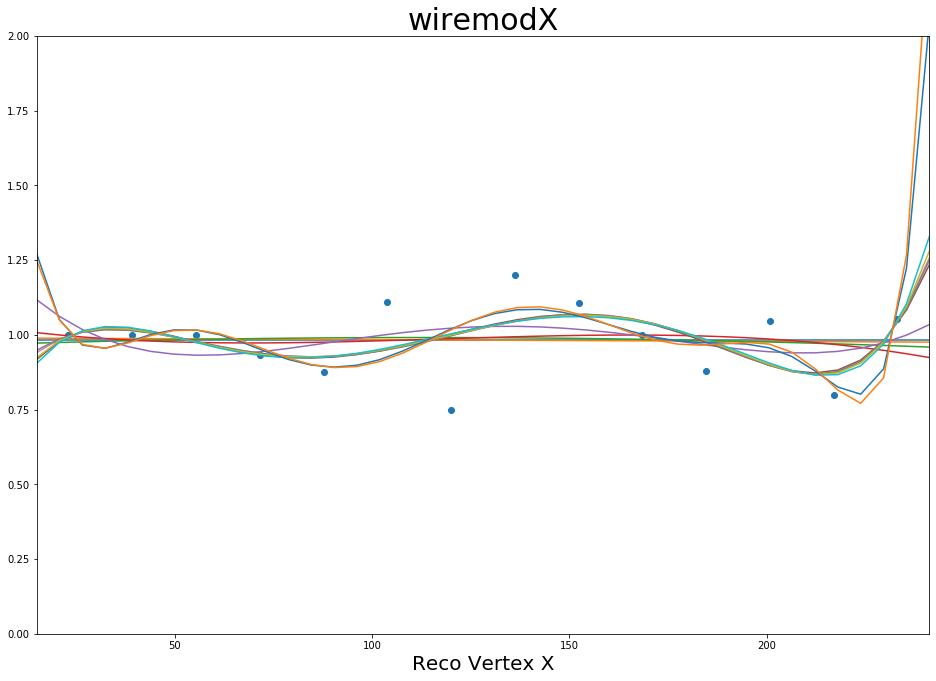

In [117]:
# The same thing with ratios

dvar = varListSel['Xreco']
nbins = 14
cov = np.zeros((nbins,nbins))
flatsys = 0.0

sysi = 0

myvardf = a_overlap_sys[sysi].query(s_cuts)
myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
var_sys = myvardf[dvar.myname]
var_cv = myvarcv[dvar.myname+'_cv']
          
hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]
truRat = np.true_divide(h0,hCV)

fig,ax = plt.subplots(figsize=(16,11))    
dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
plt.scatter(bincenters,np.true_divide(h0,hCV),label='Variation/CV')

# polyfit
aics = []
degs = []
for deg in range(nbins-2):
        
    params = deg + 1
    polyRat = np.polyfit(bincenters, truRat, deg)
    fRat = np.poly1d(polyRat)
    h0_fit = fRat(bincenters)*hCV
    
    # now calculate chi2 for fit
    print('testneg,testzero:',np.sqrt(h0_fit),hCV)
    yerr_rat = np.true_divide(np.sqrt(h0_fit),hCV)
    chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat),2).sum()
    aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
    print('degree:',deg,'chi2:',chi2_fit,'AIC:',aic)
    plt.plot(dvarLinspace,fRat(dvarLinspace),label='PolyFit (%i)'%polyterms)
    aics.append(aic)
    degs.append(deg)
    

print(degs[np.argmin(aics)])

ax.set_title(s_detsyslist[sysi],fontsize=30)
ax.set_xlabel(dvar.mylabel,fontsize=20)
#ax.legend(fontsize=15)
      
ax.set_xlim(dvar.myrange)
ax.set_ylim(0,2)


window_length 1 degree: 0 chi2: 9.263592560412054 AIC: 11.596925893745388
window_length 3 degree: 0 chi2: 8.873041047947478 AIC: 11.206374381280812
window_length 3 degree: 1 chi2: 8.625229458693235 AIC: 13.716138549602327
window_length 3 degree: 2 chi2: 9.26359256041205 AIC: 17.66359256041205
window_length 5 degree: 0 chi2: 8.878586485910798 AIC: 11.211919819244132
window_length 5 degree: 1 chi2: 8.618203262808063 AIC: 13.709112353717153
window_length 5 degree: 2 chi2: 8.762149528124052 AIC: 17.16214952812405
window_length 5 degree: 3 chi2: 8.827626905939193 AIC: 21.272071350383634
window_length 5 degree: 4 chi2: 9.26359256041205 AIC: 26.76359256041205
window_length 7 degree: 0 chi2: 8.958226898628284 AIC: 11.291560231961618
window_length 7 degree: 1 chi2: 8.568924482314452 AIC: 13.659833573223544
window_length 7 degree: 2 chi2: 8.704847251526996 AIC: 17.104847251526994
window_length 7 degree: 3 chi2: 8.82672819886712 AIC: 21.271172643311566
window_length 7 degree: 4 chi2: 8.8252614464

(0, 2)

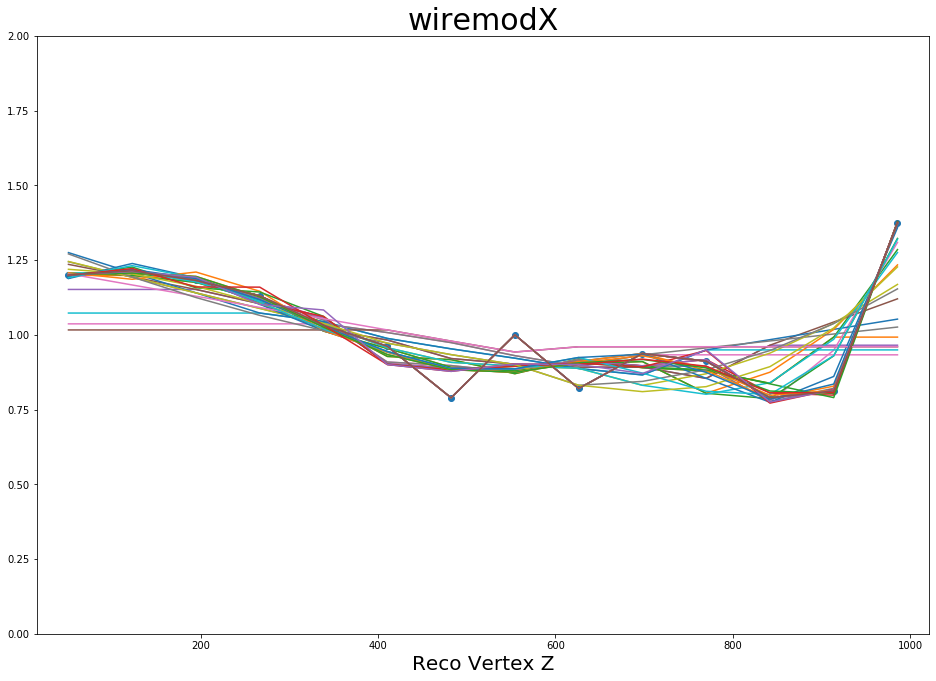

In [77]:
# The same thing with ratios

dvar = varListSel['Zreco']
nbins = 14
cov = np.zeros((nbins,nbins))
flatsys = 0.0

sysi = 0

myvardf = a_overlap_sys[sysi].query(s_cuts)
myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
var_sys = myvardf[dvar.myname]
var_cv = myvarcv[dvar.myname+'_cv']
          
hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]
truRat = np.true_divide(h0,hCV)

fig,ax = plt.subplots(figsize=(16,11))    
dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
plt.scatter(bincenters,np.true_divide(h0,hCV),label='Variation/CV')

# polyfit
for window_length in range(1,nbins-1,2):
    for deg in range(window_length):
        
        params = deg + 1
        sgRat = signal.savgol_filter(np.true_divide(h0,hCV), window_length, deg)
        h0_fit = sgRat*hCV
     
         # now calculate chi2 for fit
        yerr_rat = np.true_divide(np.sqrt(h0_fit),hCV)
        chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat),2).sum()
        aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
        print('window_length',window_length,'degree:',deg,'chi2:',chi2_fit,'AIC:',aic)
        plt.plot(bincenters,sgRat,label='Sigfit (%i)'%polyterms)
    
ax.set_title(s_detsyslist[sysi],fontsize=30)
ax.set_xlabel(dvar.mylabel,fontsize=20)
#ax.legend(fontsize=15)
      
ax.set_xlim(dvar.myrange)
ax.set_ylim(0,2)

In [ ]:


if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:
    
    fig,ax = plt.subplots(figsize=(16,11))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    hSys =  []
    
    for i in range(len(s_detsyslist)):
        var_sys = a_df_sys[i].query(s_cuts)[dist.myname]
        sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[i]
        h0,_ = np.histogram(var_sys,range=dist.myrange,bins=dumpbins,weights=sys_scale)
        h1,_,_ = ax0.hist(var_sys,range=dist.myrange,bins=dumpbins,histtype='step',label=s_detsyslist[i]+' (%i)'%h0.sum(),linewidth=2,weights=sys_scale)
        hSys.append(h1)
    
    var_cv = df_cv.query(s_cuts)[dist.myname]
    cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
    h0,_ = np.histogram(var_cv,range=dist.myrange,bins=dumpbins,weights=cv_scale)
    hCV,binedges,_ = ax0.hist(var_cv,range=dist.myrange,bins=dumpbins,histtype='step',label='CV (%i)'%h0.sum(),linewidth=3,color='black',linestyle='--',weights=cv_scale)       
    
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax0.set_xlabel(dist.mylabel,fontsize=25)
    ax0.set_title('BNB Overlay w/ Detsys',fontsize=15)
    ax0.set_xlim(dist.myrange)
    ax1.set_xlim(dist.myrange)
    ax1.set_ylim(0,2.5)
    ax0.legend(fontsize=15)
    
    for i in range(len(hSys)):
        ydots = np.true_divide(hSys[i],hCV,where=hCV!=0)
        xdots = binedges[:-1] + (binedges[1]-binedges[0])/float(len(hSys)) * i
        ax1.scatter(xdots,ydots)
    
    ax1.axhline(1,linestyle=':',color='maroon')
    
    for j in range(len(hCV)):
        ax1.axvline(binedges[j+1],linestyle=':',color='gray') 
    
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

## Smearing

In [51]:
dumphole = 'DetSysSmear'
dumpfolder = '../PlotDumps'

dumphole = '%s/%s'%(dumpfolder,dumphole)
if not os.path.exists(dumphole):
    os.makedirs(dumphole)
if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:

    fig,ax = plt.subplots(figsize=(16,11))
    binwidth = (dvar.myrange[1]-dvar.myrange[0])/float(14)
    myrange = (-3*binwidth,3*binwidth)
    nbins = 15

    for sysi in range(len(a_df_sys)):
        myvardf = a_overlap_sys[sysi].query(s_cuts)
        myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
        var_sys = myvardf[dvar.myname]
        var_cv = myvarcv[dvar.myname+'_cv']
        
        h0,binedges,_ = plt.hist((var_cv-var_sys),bins=nbins,range=myrange,histtype='step',label=s_detsyslist[sysi],linewidth=3) 
    
    ax.axvline(binwidth,label='+1 Binwidth',linestyle=':')
    ax.axvline(-binwidth,label='-1 Binwidth',linestyle=':')
    ax.set_title('(CV - Detsys)',fontsize=30)
    ax.set_xlabel(r'$\Delta$'+dvar.mylabel,fontsize=20)
    ax.legend(fontsize=25)
    plt.savefig(dumphole+'/'+dvar.myname+'.png')
    plt.close(fig)
    

NameError: name 'varlistSel' is not defined

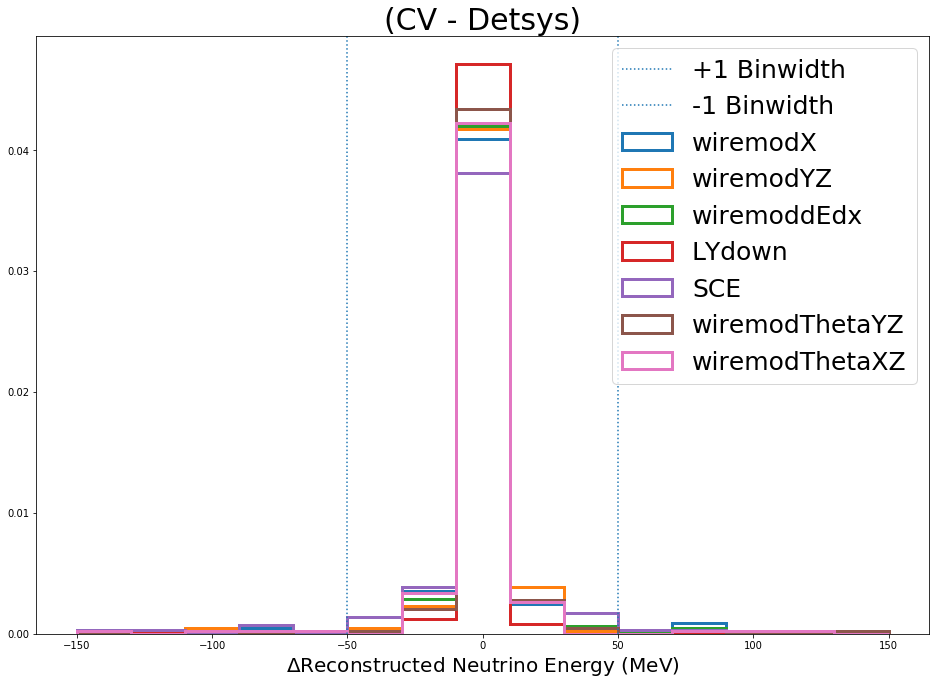

In [150]:
dvar = varListSel['Enu_1m1p']

fig,ax = plt.subplots(figsize=(16,11))
binwidth = (dvar.myrange[1]-dvar.myrange[0])/float(14)
myrange = (-3*binwidth,3*binwidth)
nbins = 15

for sysi in range(len(a_df_sys)):
    myvardf = a_overlap_sys[sysi].query(s_cuts)
    myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
    var_sys = myvardf[dvar.myname]
    var_cv = myvarcv[dvar.myname+'_cv']
        
    h0,binedges,_ = plt.hist((var_cv-var_sys),bins=nbins,range=myrange,histtype='step',label=s_detsyslist[sysi],linewidth=3,density=1) 
    
ax.axvline(binwidth,label='+1 Binwidth',linestyle=':')
ax.axvline(-binwidth,label='-1 Binwidth',linestyle=':')
ax.set_title('(CV - Detsys)',fontsize=30)
ax.set_xlabel(r'$\Delta$'+dvar.mylabel,fontsize=20)
ax.legend(fontsize=25)

## Extras

In [83]:
dumpbins = 18
dumphole = '/home/dcianci/Downloads/detsys_may18_presel' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:
    
    fig,ax = plt.subplots(figsize=(16,11))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    hSys =  []
    
    for i in range(len(s_detsyslist)):
        var_sys = a_df_sys[i][dist.myname]
        sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[i]
        h0,_ = np.histogram(var_sys,range=dist.myrange,bins=dumpbins,weights=sys_scale)
        h1,_,_ = ax0.hist(var_sys,range=dist.myrange,bins=dumpbins,histtype='step',label=s_detsyslist[i]+' (%.4f)'%h0.sum(),linewidth=2,weights=sys_scale)
        hSys.append(h1)
    
    var_cv = df_cv[dist.myname]
    cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
    h0,_ = np.histogram(var_cv,range=dist.myrange,bins=dumpbins,weights=cv_scale)
    hCV,binedges,_ = ax0.hist(var_cv,range=dist.myrange,bins=dumpbins,histtype='step',label='CV (%.4f)'%h0.sum(),linewidth=3,color='black',linestyle='--',weights=cv_scale)
    
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax0.set_xlabel(dist.mylabel,fontsize=25)
    ax0.set_title('BNB Overlay w/ Detsys',fontsize=15)
    ax0.set_xlim(dist.myrange)
    ax1.set_xlim(dist.myrange)
    ax0.legend(fontsize=15)
    ax1.set_ylim(0,2.5)
    
    for i in range(len(hSys)):
        ydots = np.true_divide(hSys[i],hCV,where=hCV!=0)
        xdots = binedges[:-1] + (binedges[1]-binedges[0])/float(len(hSys)) * i
        ax1.scatter(xdots,ydots)
    
    ax1.axhline(1,linestyle=':',color='maroon')
    
    for j in range(len(hCV)):
        ax1.axvline(binedges[j+1],linestyle=':',color='gray') 
    
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
